# Abstract

Keyword: Linear Regression, Encoding, Forward Selection, Residual Plot Diagnosis, Feature Engineering, Interaction Terms

Final Result: 22358


# Preparation

In [21]:
# Packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LinearRegression
from math import sqrt

In [22]:
train_data = pd.read_csv('/content/drive/MyDrive/6100 Data/Housing_Data_Train.csv') # Read the training data set.
test_data = pd.read_csv('/content/drive/MyDrive/6100 Data/Housing_Data_Test.csv') # Read the test data set.

# Data Pre-processing

## NA Values

In [23]:
# Check the NaN values
for column in train_data:
    if train_data[column].isna().any():
        print(f"Column '{column}' contains NaN values")

Column 'LotFrontage' contains NaN values
Column 'Alley' contains NaN values
Column 'MasVnrType' contains NaN values
Column 'MasVnrArea' contains NaN values
Column 'BsmtQual' contains NaN values
Column 'BsmtCond' contains NaN values
Column 'BsmtExposure' contains NaN values
Column 'BsmtFinType1' contains NaN values
Column 'BsmtFinType2' contains NaN values
Column 'Electrical' contains NaN values
Column 'FireplaceQu' contains NaN values
Column 'GarageType' contains NaN values
Column 'GarageYrBlt' contains NaN values
Column 'GarageFinish' contains NaN values
Column 'GarageQual' contains NaN values
Column 'GarageCond' contains NaN values
Column 'PoolQC' contains NaN values
Column 'Fence' contains NaN values
Column 'MiscFeature' contains NaN values


In [24]:
# Based on different variables, choose different methods to deal with NA's

# LotFrontage
train_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
"""
The LotFrontage shows linear feet of street connected to property,
which is highly impossible to be 0, here we take the median value of each neighbourhood and assign it to NA's
"""
# Alley
train_data.fillna({"Alley":'NA'}, inplace=True)
test_data.fillna({"Alley":'NA'}, inplace=True)

# MasVnrType
train_data['MasVnrType'] = train_data['MasVnrType'].fillna('None')
test_data['MasVnrType'] = train_data['MasVnrType'].fillna('None')

# MasVnrArea
median_value = train_data['MasVnrArea'].median()
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(median_value)
median_value = test_data['MasVnrArea'].median()
test_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(median_value)

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
train_data.fillna({'BsmtQual': 'NA', 'BsmtCond': 'NA', 'BsmtExposure': 'NA', 'BsmtFinType1': 'NA', 'BsmtFinType2': 'NA'}, inplace=True) # No Basement
test_data.fillna({'BsmtQual': 'NA', 'BsmtCond': 'NA', 'BsmtExposure': 'NA', 'BsmtFinType1': 'NA', 'BsmtFinType2': 'NA'}, inplace=True) # No Basement

# Electrical
most_frequent = train_data['Electrical'].mode()[0]
train_data['Electrical'] = train_data['Electrical'].fillna(most_frequent) # replace it with the most frequent value
most_frequent_test = test_data['Electrical'].mode()[0]
test_data['Electrical'] = test_data['Electrical'].fillna(most_frequent_test)

# FireplaceQU
train_data.fillna({'FireplaceQu': 'NA'}, inplace=True)
test_data.fillna({'FireplaceQu': 'NA'}, inplace=True)

# GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond
train_data.fillna({'GarageType': 'NA', 'GarageFinish': 'NA', 'GarageQual': 'NA', 'GarageCond': 'NA'}, inplace=True)  # No Garage
test_data.fillna({'GarageType': 'NA', 'GarageFinish': 'NA', 'GarageQual': 'NA', 'GarageCond': 'NA'}, inplace=True) # No Garage

# GarageYrBlt
mean_value = train_data['GarageYrBlt'].mean()
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna(mean_value)
mean_value = test_data['GarageYrBlt'].mean()
test_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna(mean_value)

# PoolQC, Fence
train_data.fillna({'PoolQC': 'NA', 'Fence': 'NA', 'MiscFeature': 'NA'}, inplace=True) # No Pool, Fence, MiscFeature
test_data.fillna({'PoolQC': 'NA', 'Fence': 'NA', 'MiscFeature': 'NA'}, inplace=True) # No Pool, Fence, MiscFeature

## Encoding

This data set contains both numerical variables and categorical categories, before doing analysis, categorical variables should be encoded with different methods based on their properties.

In [25]:
# Label Encoding

"""
Here when doing label encoding, an error occured as "ValueError: y contains previously unseen labels: '1983'"
which suggests that there are unseen values in test data set from training data set.
To solve this problem, first combine the two data sets, do the encoding, then split them back.
"""
combined_data = pd.concat([train_data, test_data], keys=['train', 'test'])

label_cols = ['MSSubClass', 'LotShape', 'LandContour', 'Utilities', 'BldgType', 'ExterQual', 'ExterCond', 'BsmtQual',
              'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
              'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(combined_data[col].astype(str))
    label_encoders[col] = le

# Split back into train and test sets
train_data = combined_data.xs('train')
test_data = combined_data.xs('test')

In [26]:
# One-Hot Encoding
combined_data = pd.concat([train_data, test_data], keys=['train', 'test'])
one_hot_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
                'Condition2', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive',
                'MiscFeature', 'SaleType', 'SaleCondition']

combined_data = pd.get_dummies(combined_data, columns=one_hot_cols, drop_first=True)

train_data = combined_data.xs('train')
test_data = combined_data.xs('test')

In [27]:
# Check data types
print(train_data.dtypes)
print(test_data.dtypes)

Unnamed: 0                 int64
Id                         int64
LotFrontage              float64
LotArea                    int64
LotShape                   int64
                          ...   
SaleCondition_AdjLand       bool
SaleCondition_Alloca        bool
SaleCondition_Family        bool
SaleCondition_Normal        bool
SaleCondition_Partial       bool
Length: 220, dtype: object
Unnamed: 0                 int64
Id                         int64
LotFrontage              float64
LotArea                    int64
LotShape                   int64
                          ...   
SaleCondition_AdjLand       bool
SaleCondition_Alloca        bool
SaleCondition_Family        bool
SaleCondition_Normal        bool
SaleCondition_Partial       bool
Length: 220, dtype: object


Notice that some of the columns are `bool`, which are `TRUE` and `FALSE` values, I prefer to convert them to 0s and 1s.

In [ ]:
# Convert Booleans to 0s and 1s in train_data and test_data
for col in train_data.select_dtypes(include='bool').columns:
    train_data[col] = train_data[col].astype(int)

for col in test_data.select_dtypes(include='bool').columns:
    test_data[col] = test_data[col].astype(int)

## Outliers

In [29]:
# Remove the highest 5% SalePrice
threshold = train_data['SalePrice'].quantile(0.95)

train_data_filtered = train_data[train_data['SalePrice'] <= threshold]

# Modelling and Model Tuning

## Linear Regression

### Regression

In [30]:
def split_data(X, Y):
    return train_test_split(X, Y, test_size=0.2, random_state=64)

def predict(X, Y):
    # Split the data into training and test sets
    X_train, X_test, Y_train, Y_test = split_data(X, Y)

    # Fit the LR
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # Make predictions on training and test sets
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(Y_train, Y_train_pred)
    train_r2 = r2_score(Y_train, Y_train_pred)
    test_mse = mean_squared_error(Y_test, Y_test_pred)
    test_r2 = r2_score(Y_test, Y_test_pred)

    # Print the results
    print(f"Root Train Mean Squared Error MSE: {sqrt(train_mse):.4f}")
    print(f"Train R-squared                  : {train_r2:.4f}")
    print(f"Root Test Mean Squared Error MSE : {sqrt(test_mse):.4f}")
    print(f"Test R-squared                   : {test_r2:.4f}")
    # Plotting prediction line
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_test, Y_test_pred, color='blue', alpha=0.5, label='Predicted')
    plt.scatter(Y_test, Y_test, color='green', alpha=0.5, label='Actual')
    plt.xlabel('Actual SalePrice')
    plt.ylabel('Predicted SalePrice')
    plt.title('Actual vs Predicted SalePrice')
    plt.legend()
    plt.show()
    """
    return {
        'train_mse': train_mse,
        'train_r2': train_r2,
        'test_mse': test_mse,
        'test_r2': test_r2,
        'coefficients': ols_sm_results.params,
        'intercept': ols_sm_results.params[0]
    }
    """

Root Train Mean Squared Error MSE: 13495.6100
Train R-squared                  : 0.9436
Root Test Mean Squared Error MSE : 45536.1951
Test R-squared                   : 0.2318


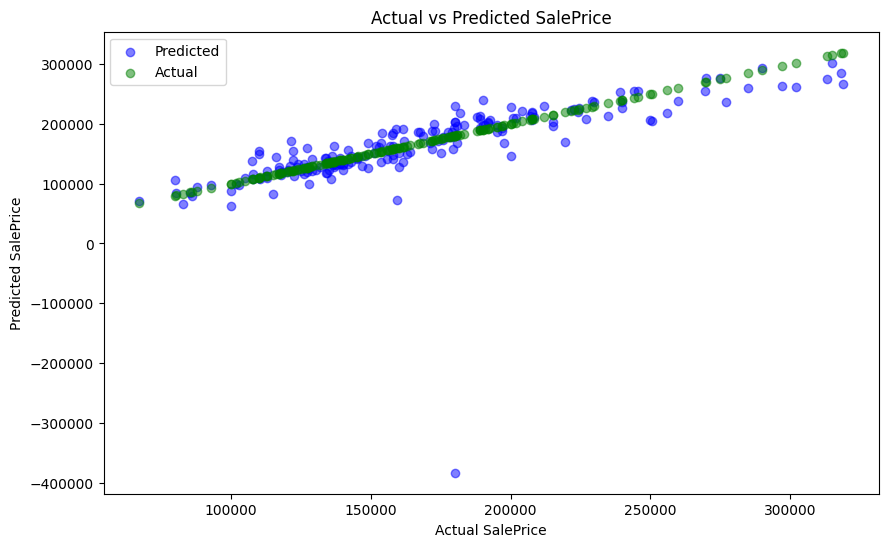

In [31]:
X = train_data_filtered.drop(columns=['SalePrice'])
Y = train_data_filtered['SalePrice']
predict(X, Y)

In [32]:
# Drop a few rows with high residual.
X = train_data_filtered.drop(columns=['SalePrice'])
Y = train_data_filtered['SalePrice']

for i in range(0,2):
    X = train_data_filtered.drop(columns=['SalePrice'])
    Y = train_data_filtered['SalePrice']

    model = LinearRegression()
    model.fit(X, Y)

    y_pred = model.predict(X)
    residuals = Y - y_pred
    largest_residual_index = np.argmax(np.abs(residuals))
    train_data_filtered = train_data_filtered.drop(index=largest_residual_index)
    print(f"Removed row {largest_residual_index} with the largest residual.")
    i += 1


Removed row 244 with the largest residual.
Removed row 243 with the largest residual.


Root Train Mean Squared Error MSE: 13915.8234
Train R-squared                  : 0.9402
Root Test Mean Squared Error MSE : 18488.0633
Test R-squared                   : 0.8708


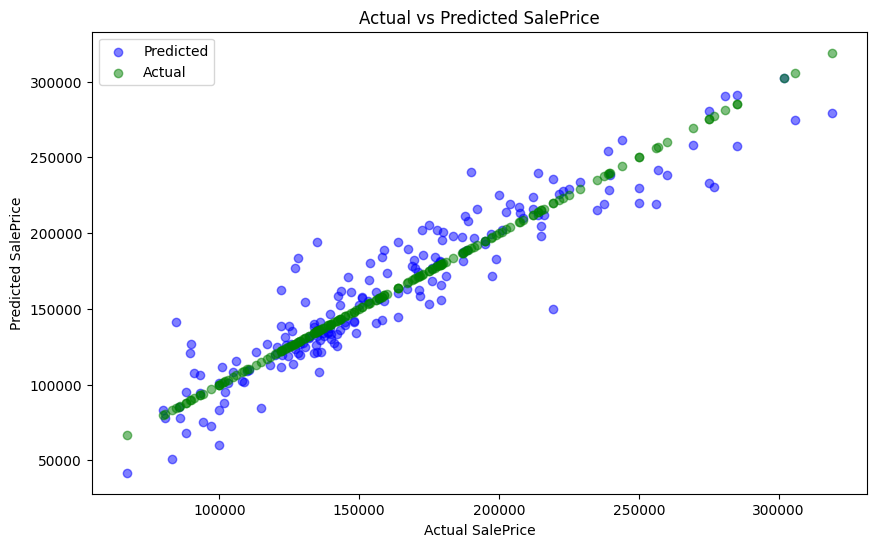

In [53]:
X = train_data_filtered.drop(columns=['SalePrice'])
Y = train_data_filtered['SalePrice']
predict(X, Y)

This suggests that the model is overfitting.

### Forward Selection

In [34]:
# Function to process a subset of features
def processSubset(feature_set, X, Y):
    model = sm.OLS(Y, sm.add_constant(X[list(feature_set)]))
    regr = model.fit()
    return {'model': regr, 'RSS': RSS}

# Forward selection function
def forward(predictors, X, Y):
    remaining_predictors = [p for p in X.columns if p not in predictors]

    results = []

    for p in remaining_predictors:
        results.append(processSubset(predictors + [p], X, Y))
    models = pd.DataFrame(results)

    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]

    return best_model

# Forward selection procedure
def forward_selection(X, Y):
    predictors = []
    models = []

    for i in range(len(X.columns)):
        best_model = forward(predictors, X, Y)
        predictors = best_model['model'].model.exog_names[1:]
        models.append(best_model)

        print(f"Step {i+1}: Selected predictors: {predictors}, RSS: {best_model['RSS']}")

    # Final selected model and predictors
    final_model = models[-1]['model']
    selected_predictors = models[-1]['model'].model.exog_names[1:]  # Get final list of predictors

    return final_model, selected_predictors

In [35]:
X = train_data_filtered.drop(columns=['SalePrice'])
Y = train_data_filtered['SalePrice']

# Run forward selection
final_model, selected_predictors = forward_selection(X, Y)

# Print final selected predictors
print("Final selected predictors: ", selected_predictors)

# Summary of the final model
print(final_model.summary())

Step 1: Selected predictors: ['OverallQual'], RSS: 1231424574415.563
Step 2: Selected predictors: ['OverallQual', 'GrLivArea'], RSS: 1014451283308.3695
Step 3: Selected predictors: ['OverallQual', 'GrLivArea', 'YearBuilt'], RSS: 858877872668.598
Step 4: Selected predictors: ['OverallQual', 'GrLivArea', 'YearBuilt', 'MSSubClass_1'], RSS: 782249598975.0325
Step 5: Selected predictors: ['OverallQual', 'GrLivArea', 'YearBuilt', 'MSSubClass_1', 'GarageCars'], RSS: 727159790885.0178
Step 6: Selected predictors: ['OverallQual', 'GrLivArea', 'YearBuilt', 'MSSubClass_1', 'GarageCars', 'Condition2_PosN'], RSS: 682521311813.9369
Step 7: Selected predictors: ['OverallQual', 'GrLivArea', 'YearBuilt', 'MSSubClass_1', 'GarageCars', 'Condition2_PosN', 'OverallCond'], RSS: 643798413414.6794
Step 8: Selected predictors: ['OverallQual', 'GrLivArea', 'YearBuilt', 'MSSubClass_1', 'GarageCars', 'Condition2_PosN', 'OverallCond', 'BsmtFullBath'], RSS: 612532178829.8424
Step 9: Selected predictors: ['OverallQu

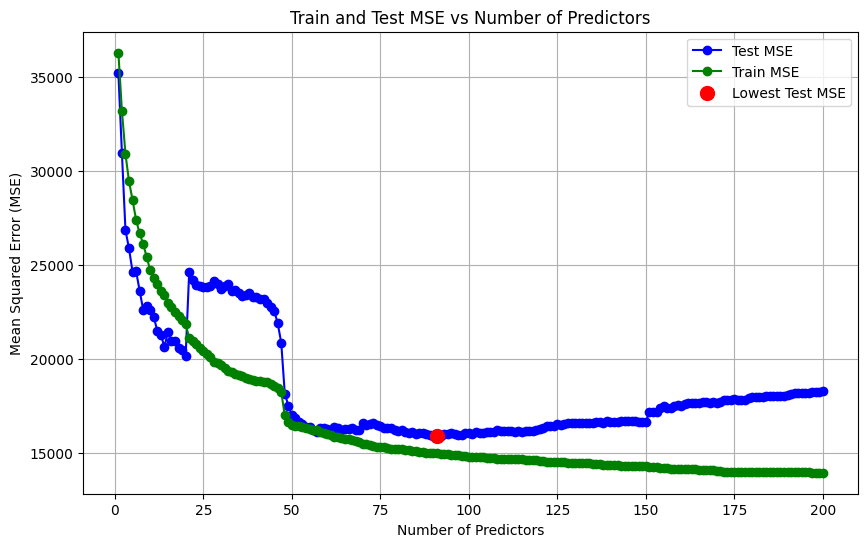

Best predictors: ['OverallQual', 'GrLivArea', 'YearBuilt', 'MSSubClass_1', 'GarageCars', 'Condition2_PosN', 'OverallCond', 'BsmtFullBath', 'KitchenQual', 'Neighborhood_ClearCr', 'MSZoning_RM', 'Condition1_Norm', 'Neighborhood_NridgHt', 'Fireplaces', 'PoolArea', 'MSSubClass_4', 'Neighborhood_NoRidge', 'ScreenPorch', 'Neighborhood_Somerst', 'Neighborhood_Crawfor', 'PoolQC', 'GarageFinish', 'Neighborhood_Edwards', 'BsmtExposure', 'KitchenAbvGr', 'Functional_Typ', 'SaleCondition_Normal', 'SaleCondition_Partial', 'Neighborhood_StoneBr', 'BldgType', 'Exterior1st_BrkFace', 'LotArea', 'LotFrontage', 'Neighborhood_NAmes', 'Condition1_RRAe', 'RoofMatl_Tar&Grv', 'Exterior2nd_Wd Shng', 'WoodDeckSF', 'Exterior1st_HdBoard', 'MasVnrType_None', 'ExterQual', 'YrSold', 'RoofMatl_CompShg', 'RoofMatl_WdShngl', 'RoofMatl_Membran', 'RoofMatl_WdShake', 'RoofMatl_Roll', 'RoofMatl_Metal', 'BsmtFinSF1', 'TotalBsmtSF', 'BedroomAbvGr', 'LandSlope_Sev', 'Exterior2nd_Plywood', 'MSSubClass_10', 'Neighborhood_Veenker

In [40]:
def evaluate_model(predictors, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X[predictors], Y, test_size=0.2, random_state=64)

    model = LinearRegression()
    model.fit(X_train, Y_train)

    # Predict and calculate MSE for training and test sets
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(Y_train, Y_train_pred)
    test_mse = mean_squared_error(Y_test, Y_test_pred)

    return train_mse, test_mse

def plot_u_shape(selected_predictors, X, Y):
    train_mse_list = []
    test_mse_list = []
    predictors_included = []

    for i in range(1, len(selected_predictors)+1):
        predictors_included.append(selected_predictors[i-1])
        train_mse, test_mse = evaluate_model(selected_predictors[:i], X, Y)

        train_mse_list.append(sqrt(train_mse))
        test_mse_list.append(sqrt(test_mse))

    # Find the index of the lowest test MSE
    best_index = np.argmin(test_mse_list)

    # Plot the U-shaped graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(selected_predictors) + 1), test_mse_list, label="Test MSE", color='blue', marker='o')
    plt.plot(range(1, len(selected_predictors) + 1), train_mse_list, label="Train MSE", color='green', marker='o')

    # Red mark the lowest test MSE point
    plt.scatter(best_index + 1, test_mse_list[best_index], color='red', s=100, zorder=5, label='Lowest Test MSE')

    plt.xlabel('Number of Predictors')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Train and Test MSE vs Number of Predictors')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the feature group with the lowest test MSE
    return predictors_included[:best_index], test_mse_list[best_index]

best_predictors, best_test_mse = plot_u_shape(selected_predictors[:200], train_data_filtered.drop(columns = ['SalePrice']), train_data_filtered['SalePrice'])

print(f"Best predictors: {best_predictors}")

Root Train Mean Squared Error MSE: 14970.0258
Train R-squared                  : 0.9307
Root Test Mean Squared Error MSE : 15895.9071
Test R-squared                   : 0.9045


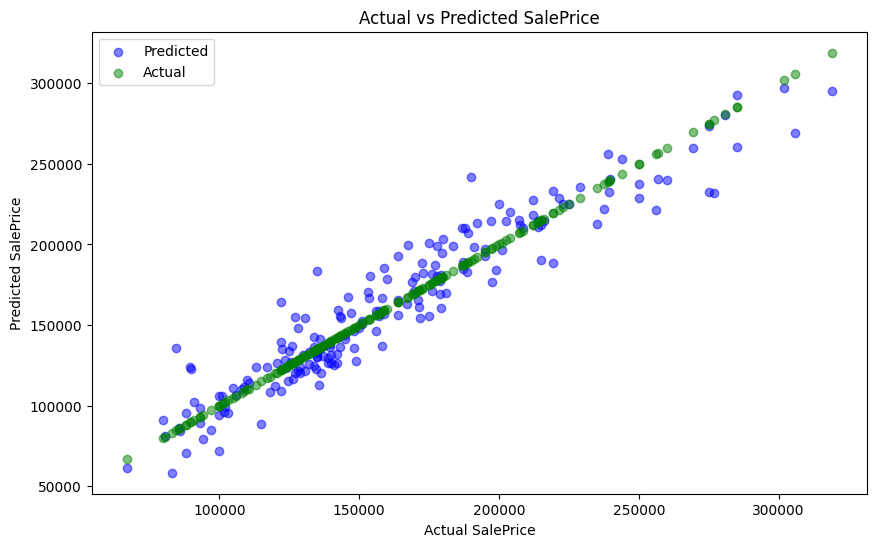

In [41]:
X = train_data_filtered[best_predictors]
Y = train_data_filtered['SalePrice']
predict(X, Y)

### On Whole Data Set & Leaderboard Result 1

In [42]:
# Test the model on the whole data set.
X = train_data_filtered.drop(columns=['SalePrice'])
Y = train_data_filtered['SalePrice']
model = LinearRegression()
model.fit(X, Y)
predictions = model.predict(train_data.drop(columns=['SalePrice']))
mse = mean_squared_error(train_data['SalePrice'], predictions)
print(f"RMSE: {sqrt(mse)}")

RMSE: 23749.24021817598


In [43]:
X = train_data_filtered[best_predictors]
Y = train_data_filtered['SalePrice']
model = LinearRegression()
model.fit(X, Y)
predictions = model.predict(test_data[best_predictors])

#convert the predictions to a LIST of POSITIVE INTEGERS (do not submit decimals!)
list_predictions = predictions.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[195163, 133357, 117069, 139569, 126616, 244697, 67582, 185964, 153684, 170674, 145204, 267893, 273932, 174139, 150167, 351676, 130687, 159027, 217537, 67686, 117465, 199415, 165639, 191275, 120809, 119668, 200566, 198694, 182999, 111783, 139206, 156807, 310676, 242842, 159520, 177169, 108294, 143441, 217248, 219110, 155099, 169575, 209028, 109220, 138921, 100279, 129179, 234864, 261875, 183776, 250448, 174363, 132323, 209671, 170440, 180358, 117350, 194239, 147994, 128498, 120976, 103396, 151013, 132695, 213314, 235416, 187410, 219797, 267283, 101342, 213152, 249723, 83096, 235906, 157551, 211603, 110623, 185222, 113724, 164986, 127383, 183901, 227251, 231976, 137063, 240020, 264456, 136563, 262005, 183442, 168691, 192309, 305963, 146872, 144194, 84148, 131577, 209989, 153207, 90429, 204326, 134546, 290652, 173003, 123612, 122296, 204634, 155355, 269863, 304627, 219221, 212547, 59063, 140183, 107415, 141782, 152010, 223395, 246554, 283045, 245310, 211196, 299213, 141937, 105458, 20128

From the best_predictors, we get a final root test mse of 24301 on the leaderboard.

## Other Attempts

### Model Diagnosis - Residual

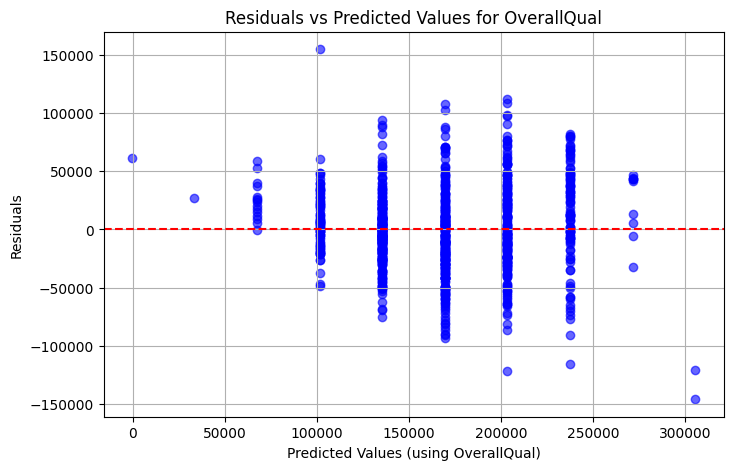

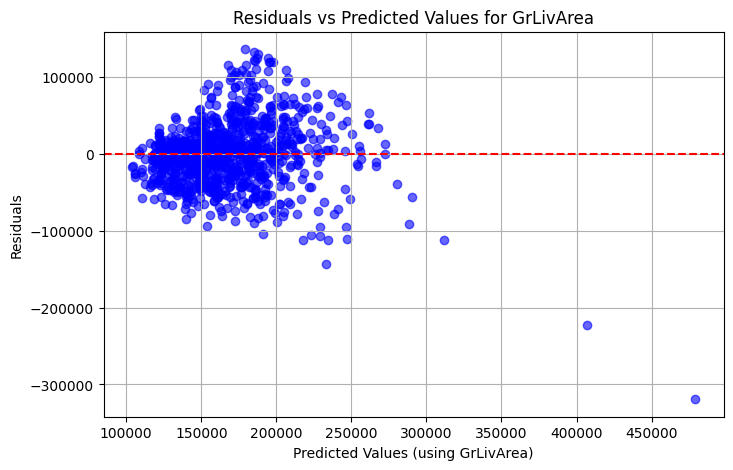

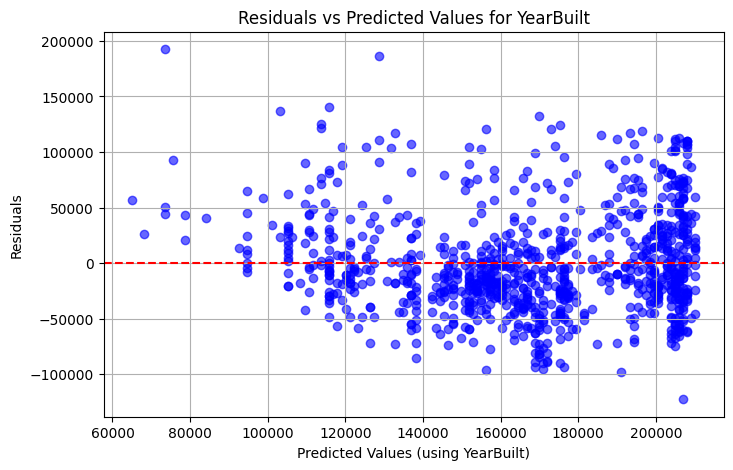

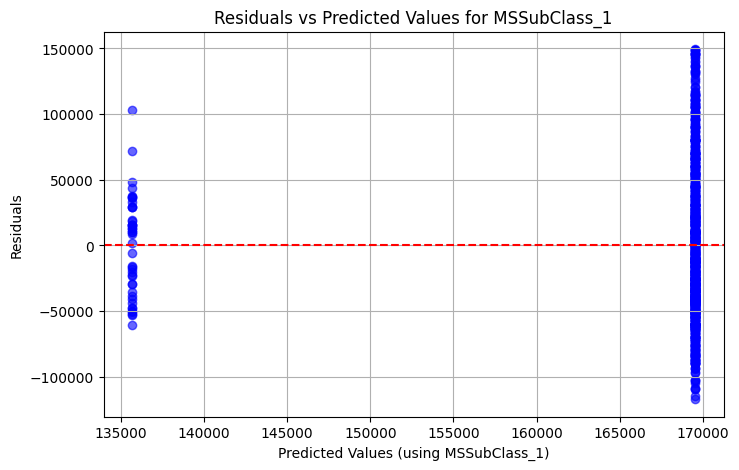

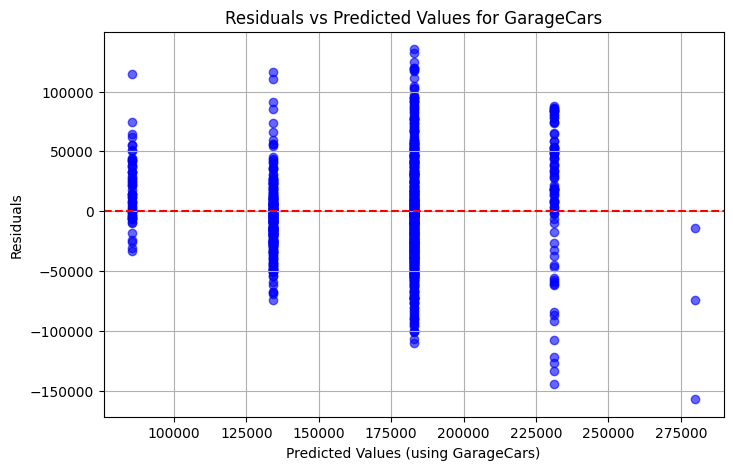

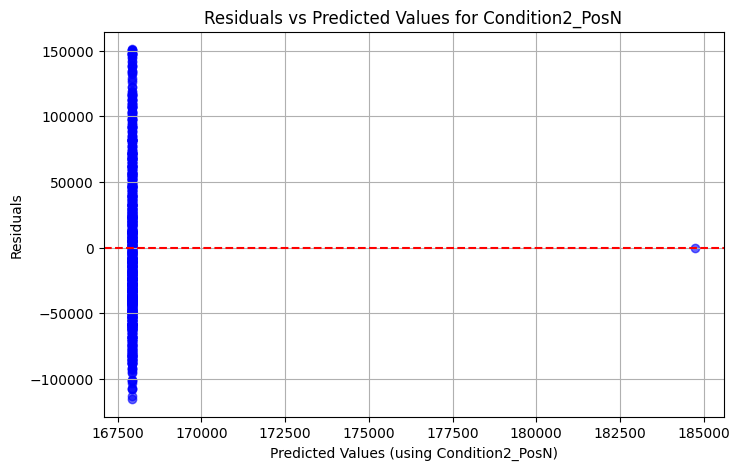

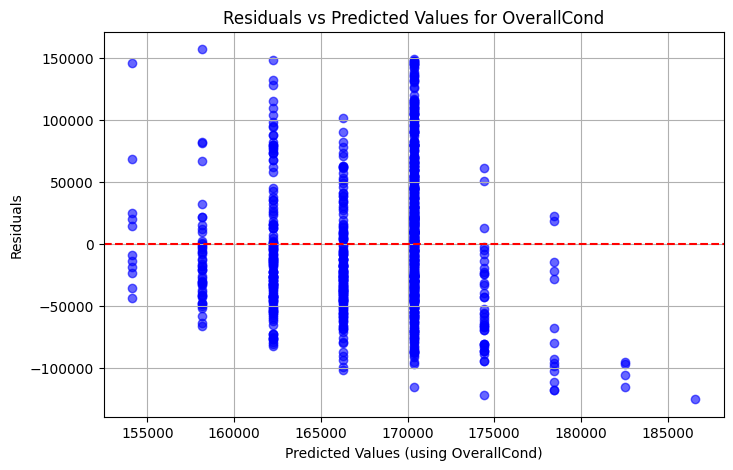

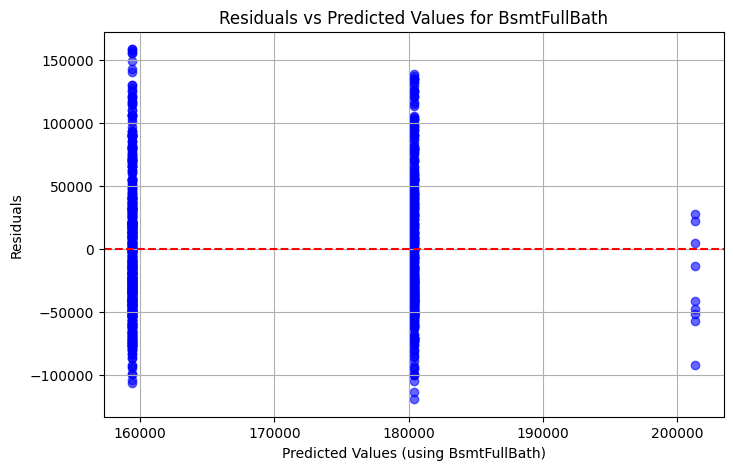

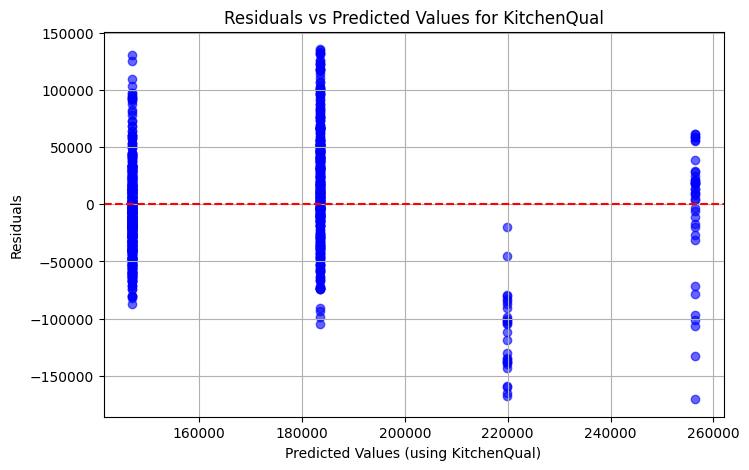

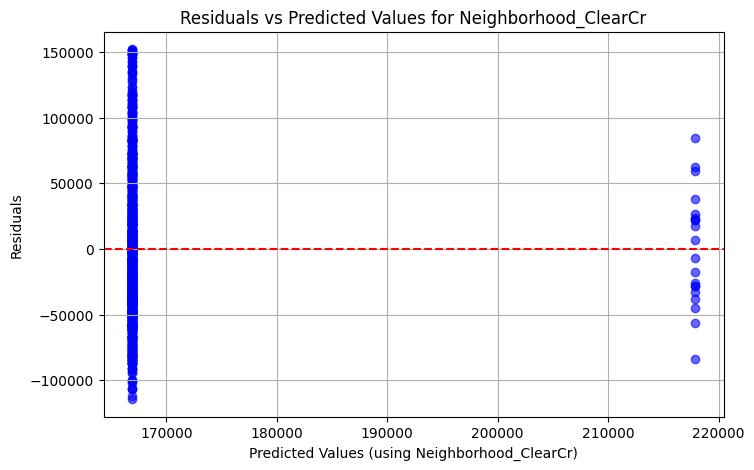

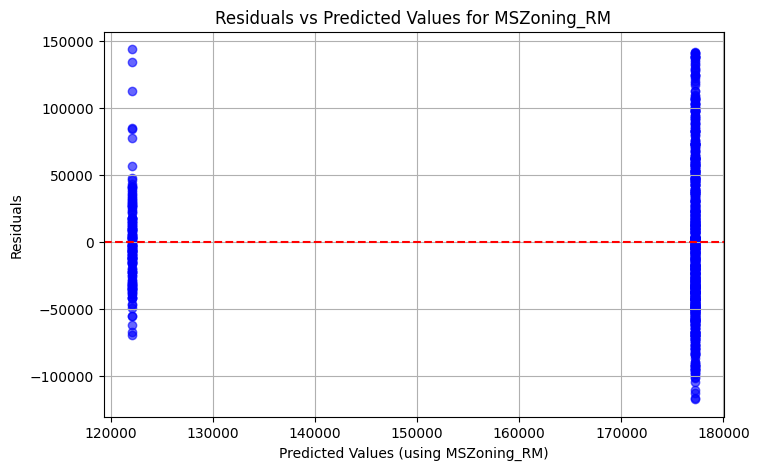

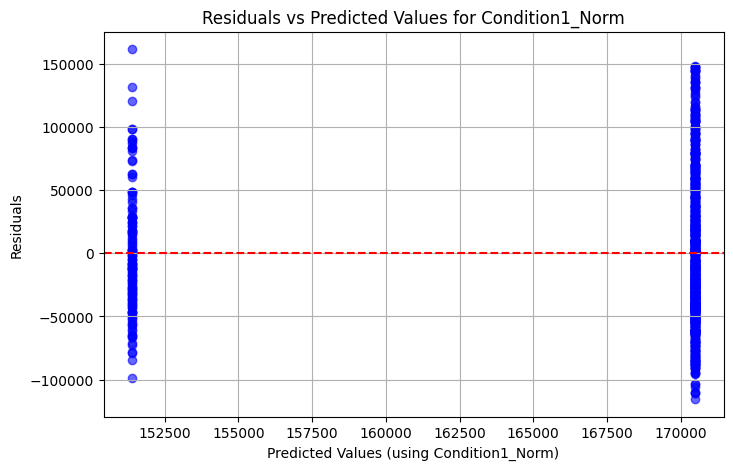

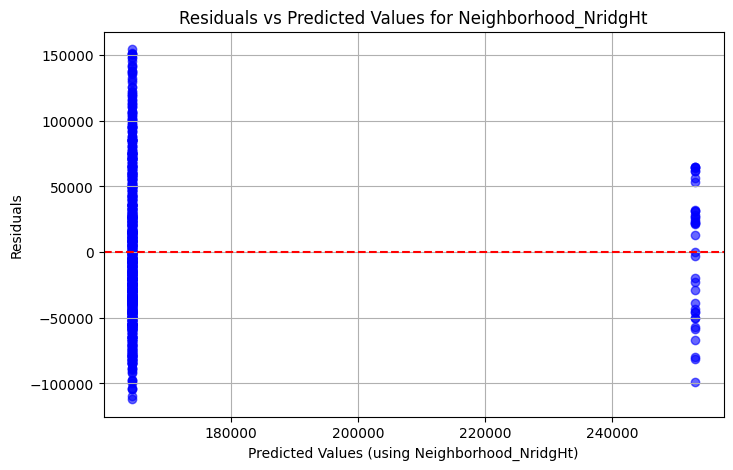

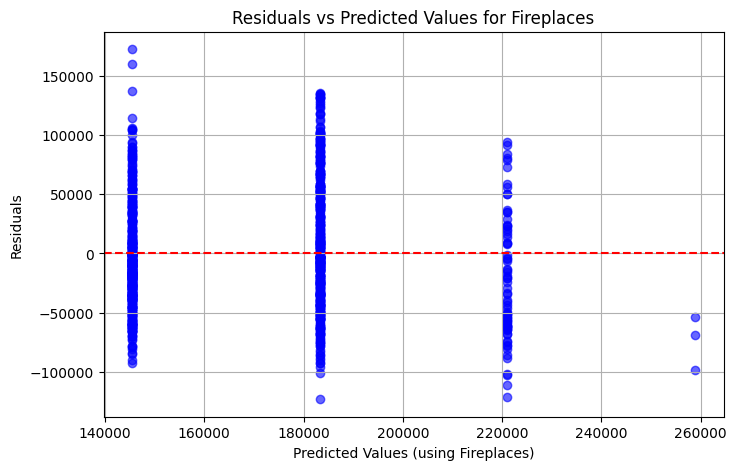

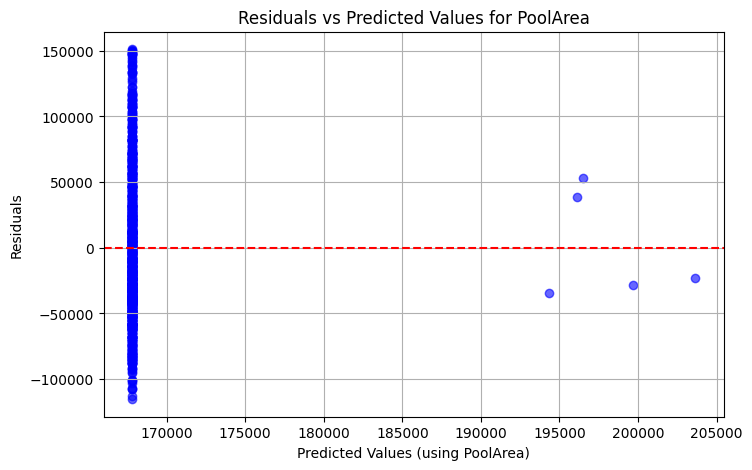

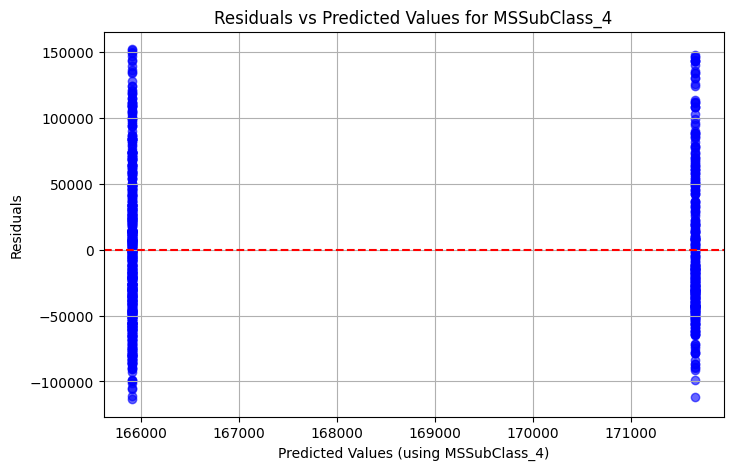

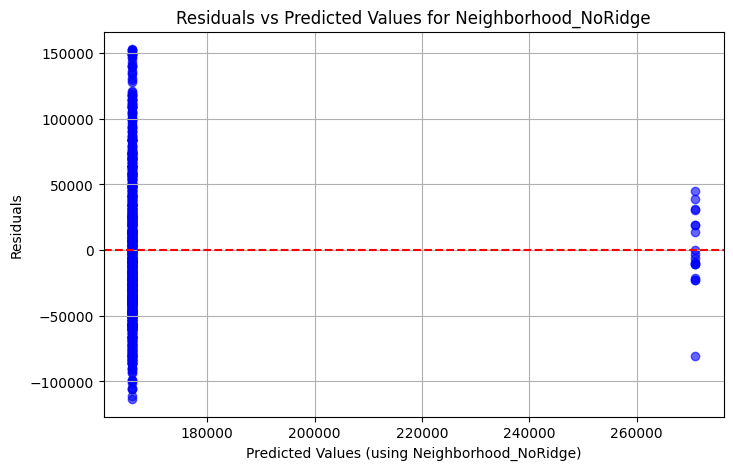

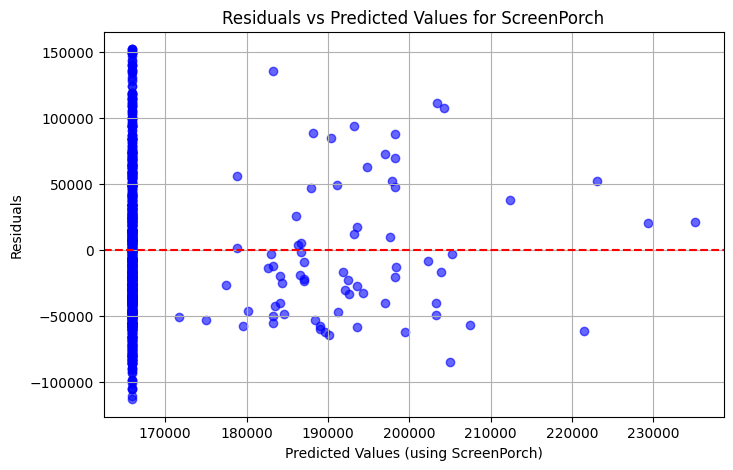

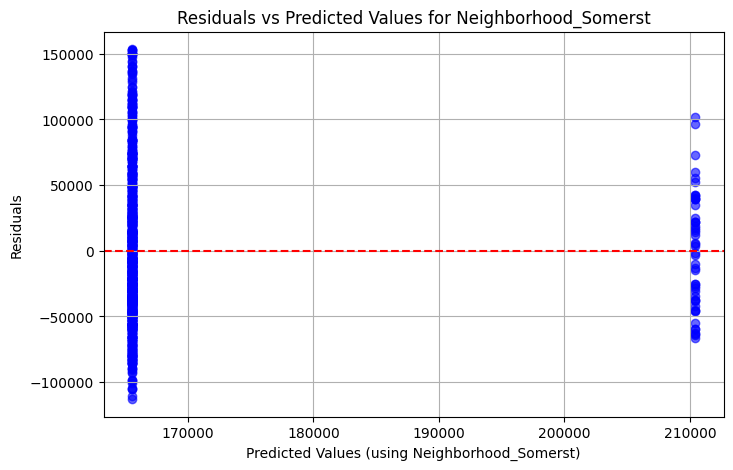

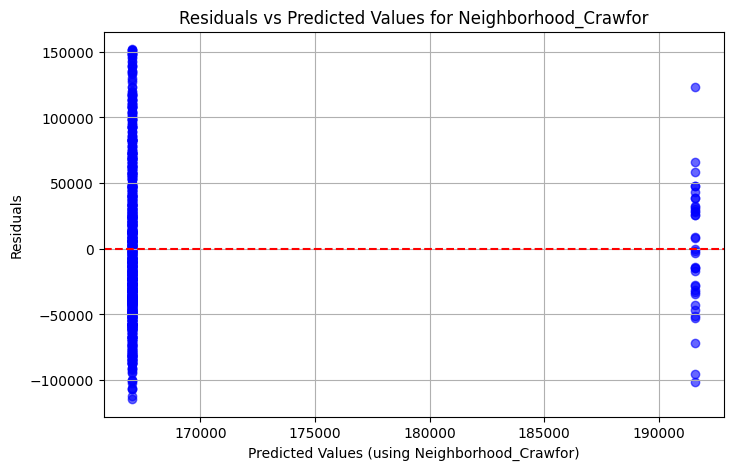

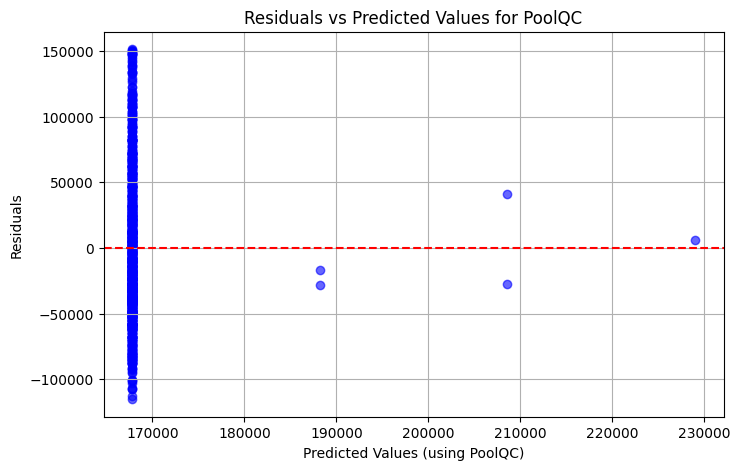

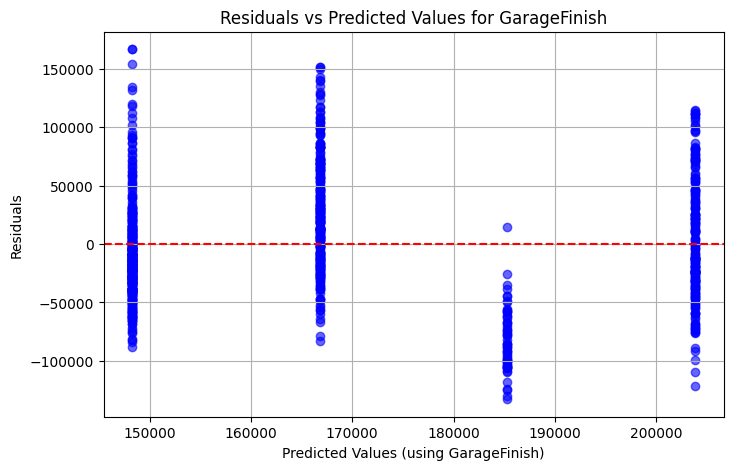

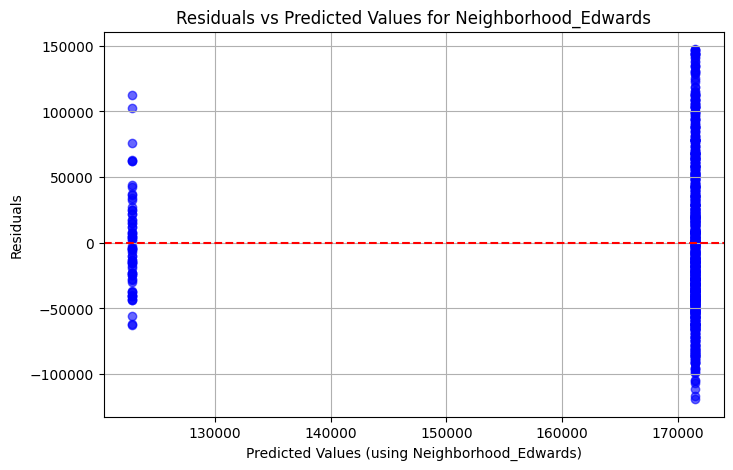

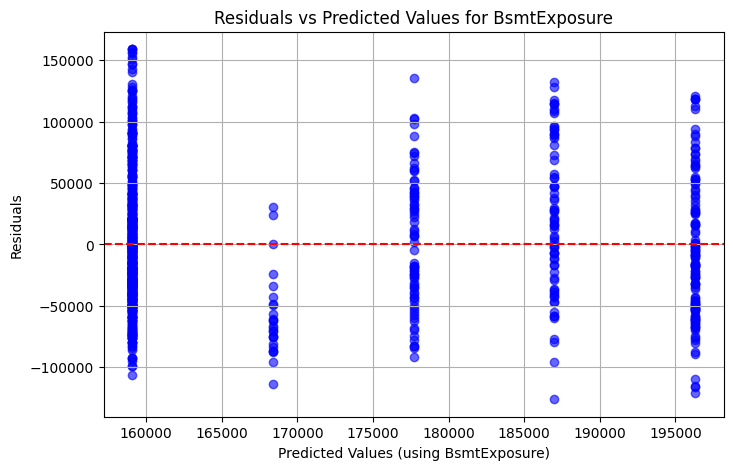

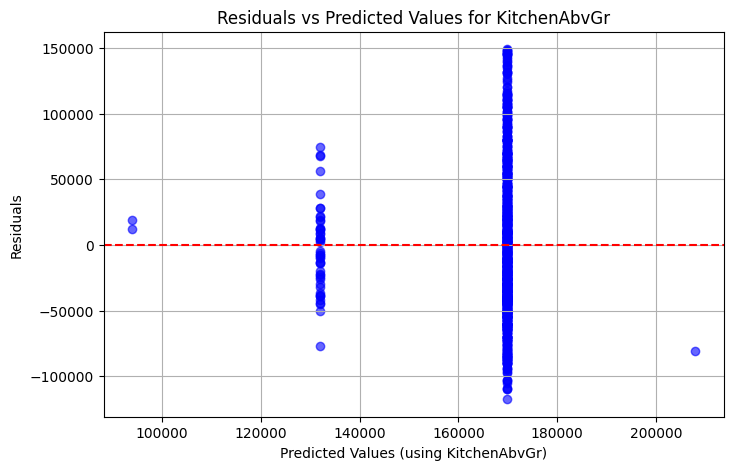

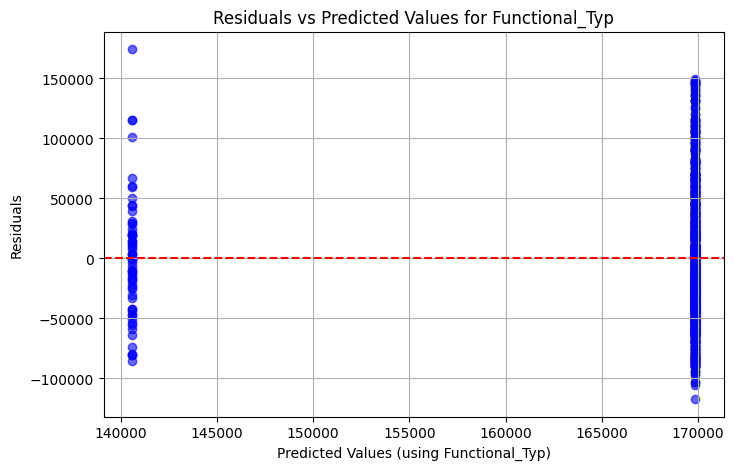

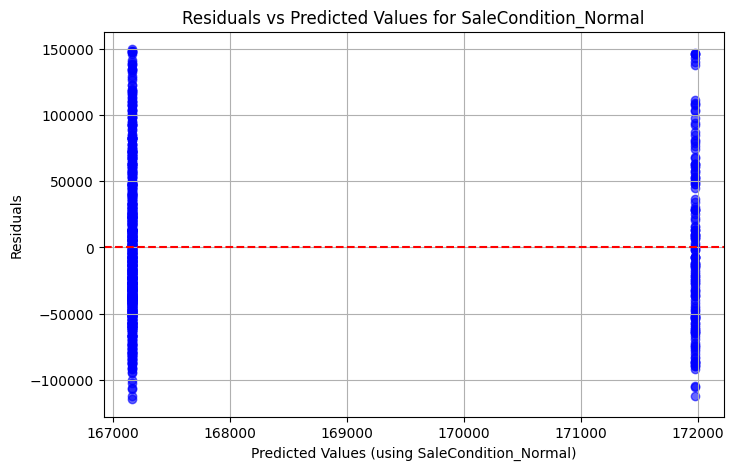

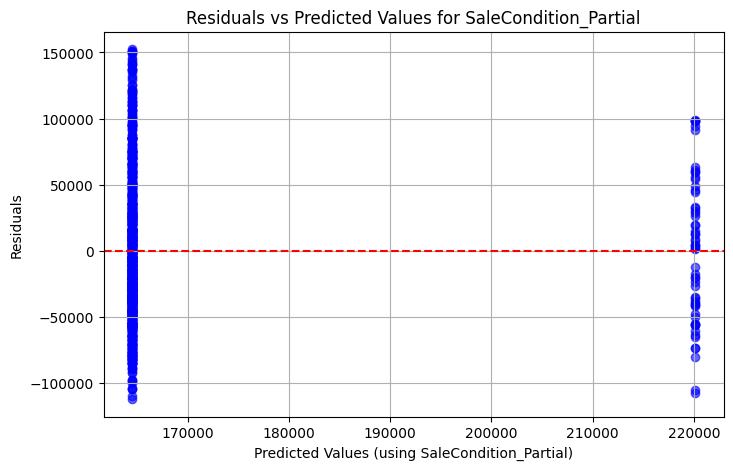

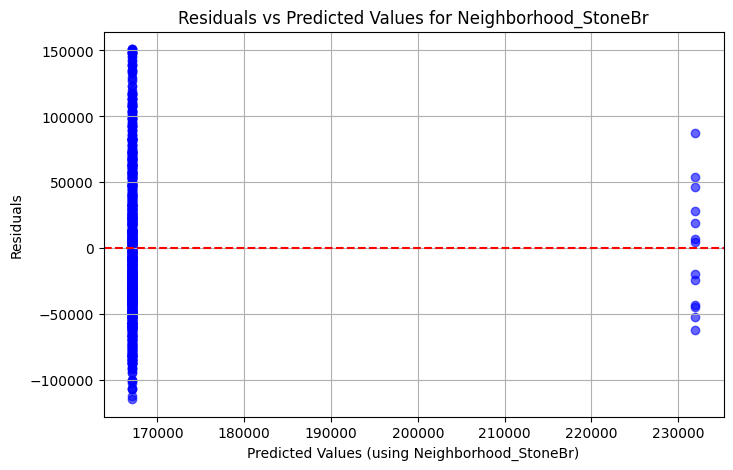

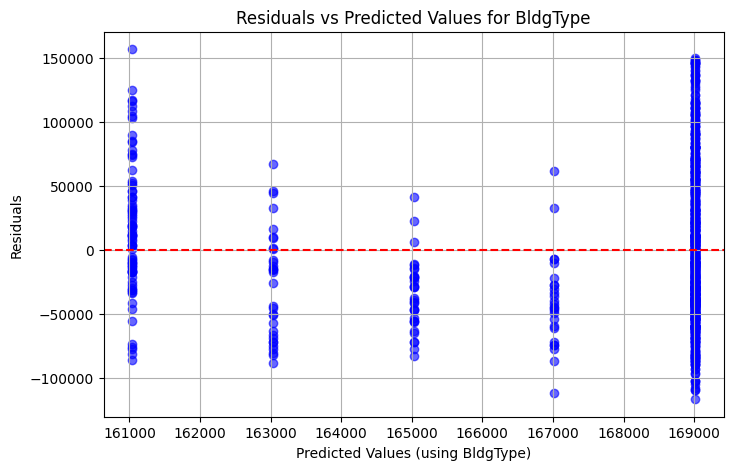

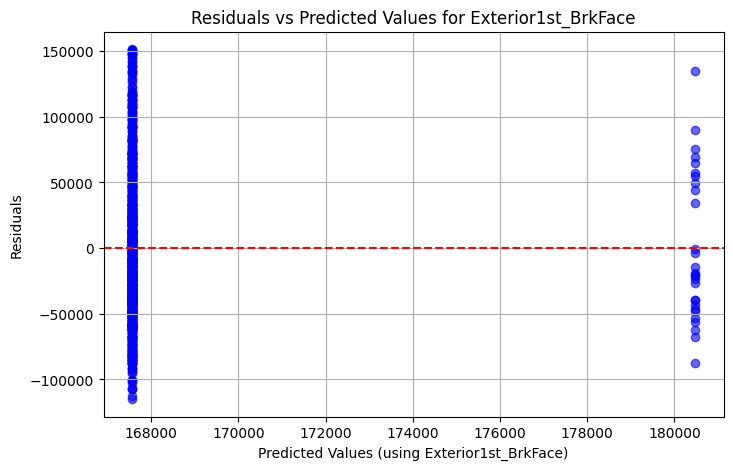

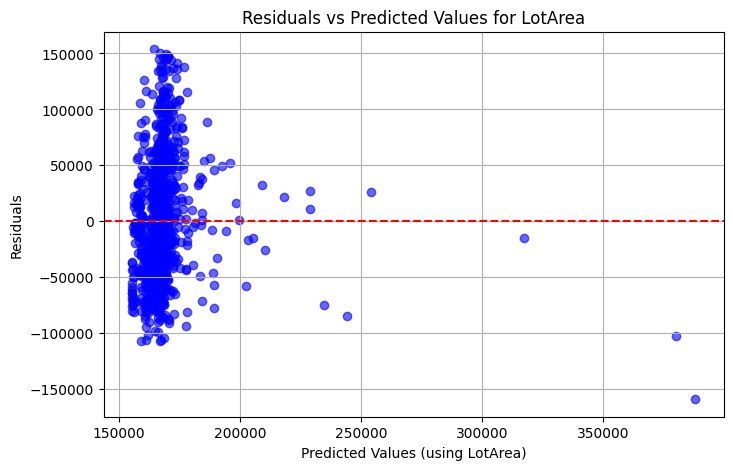

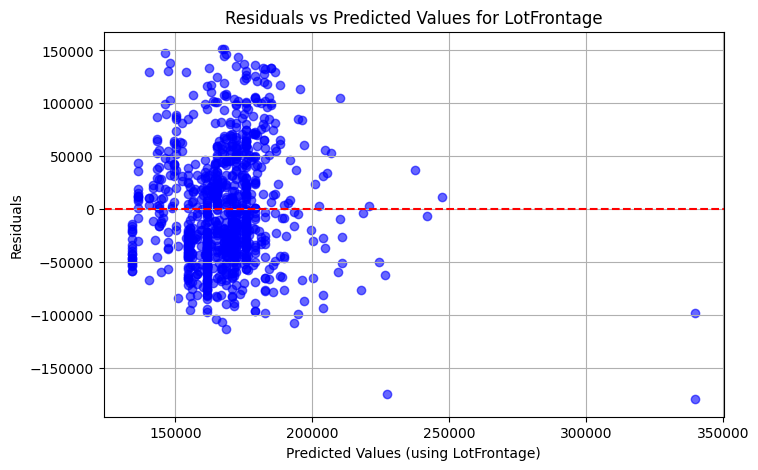

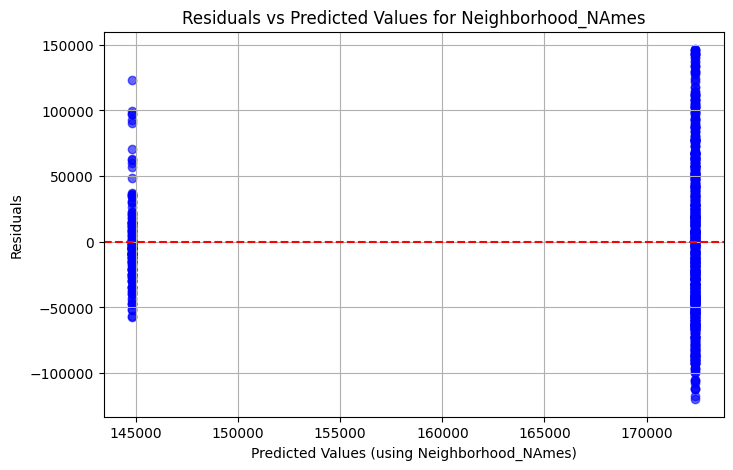

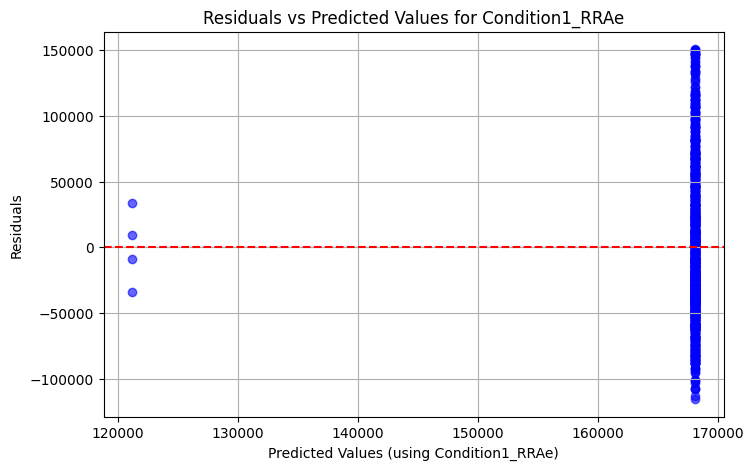

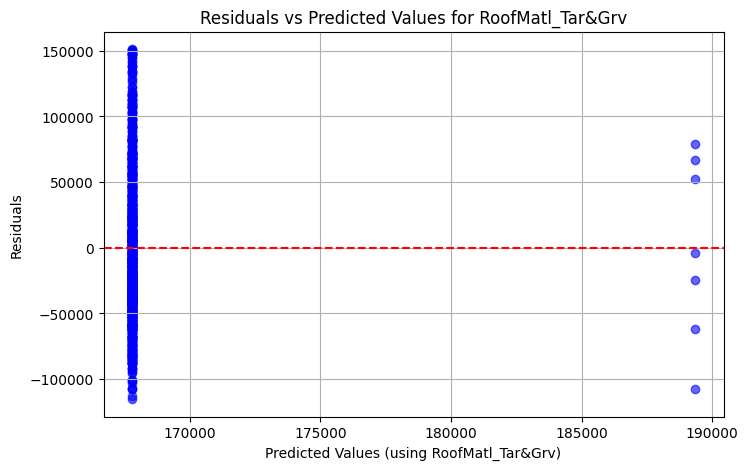

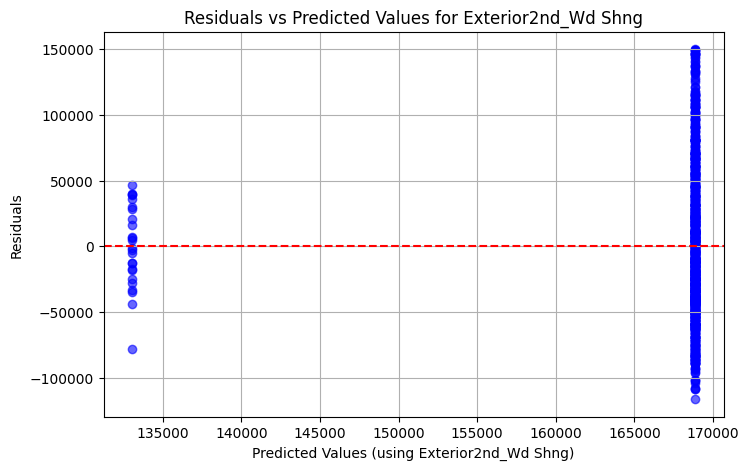

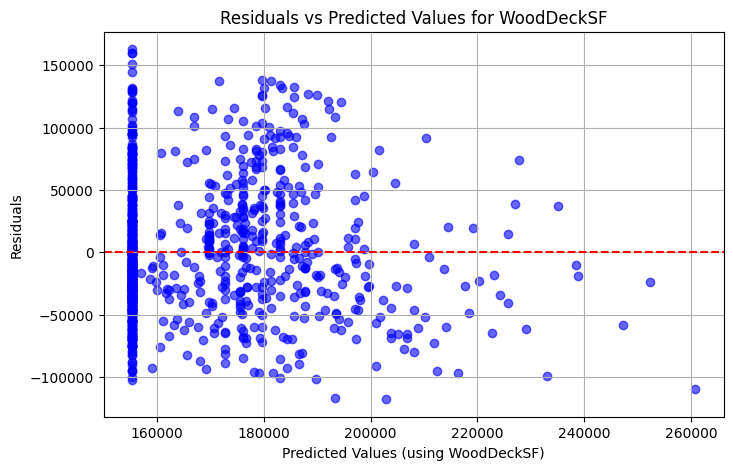

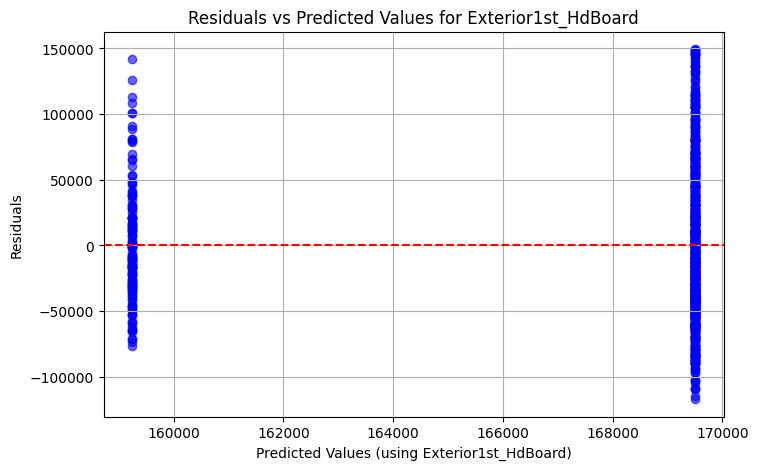

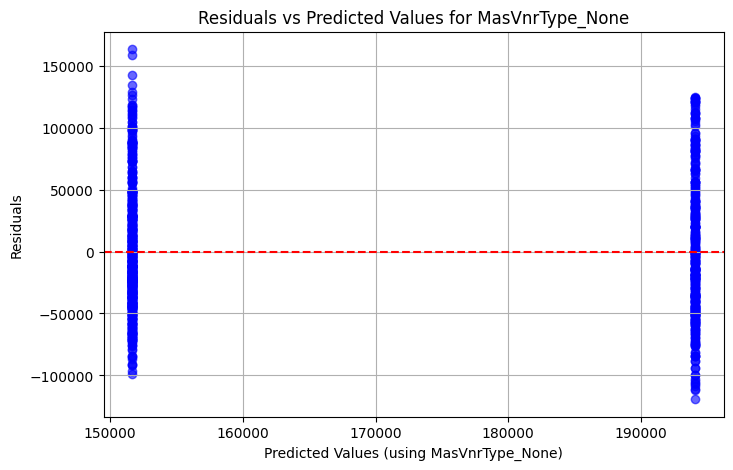

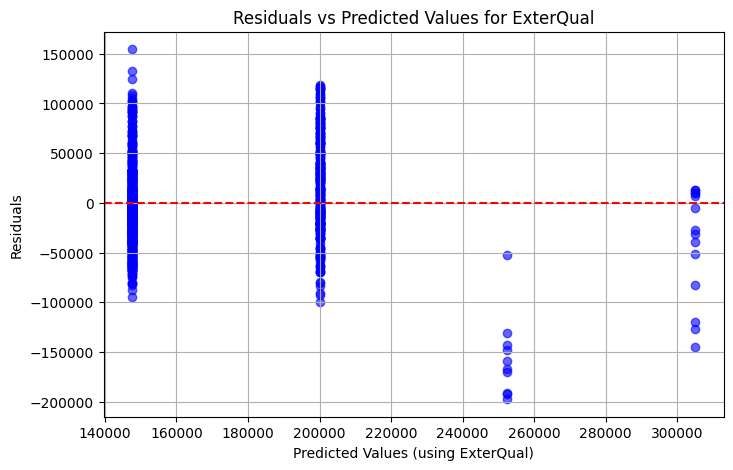

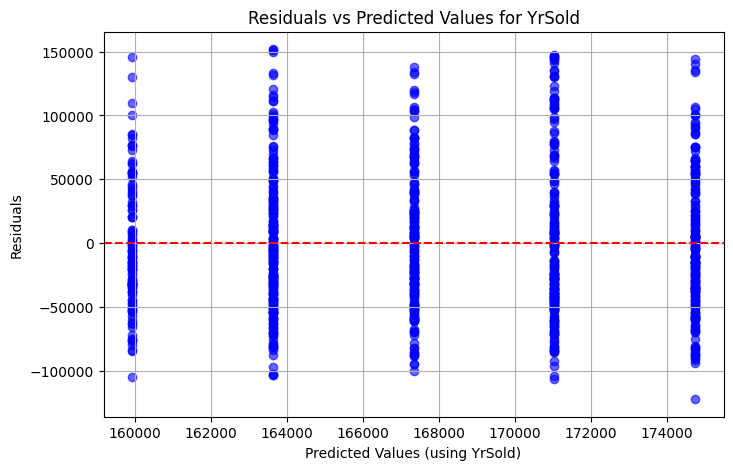

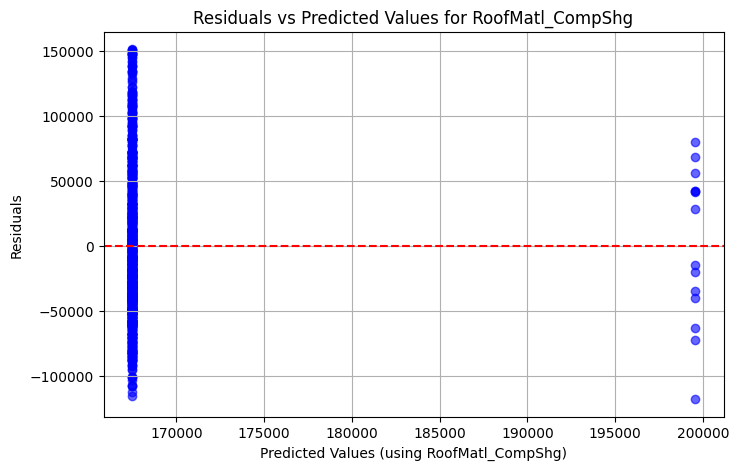

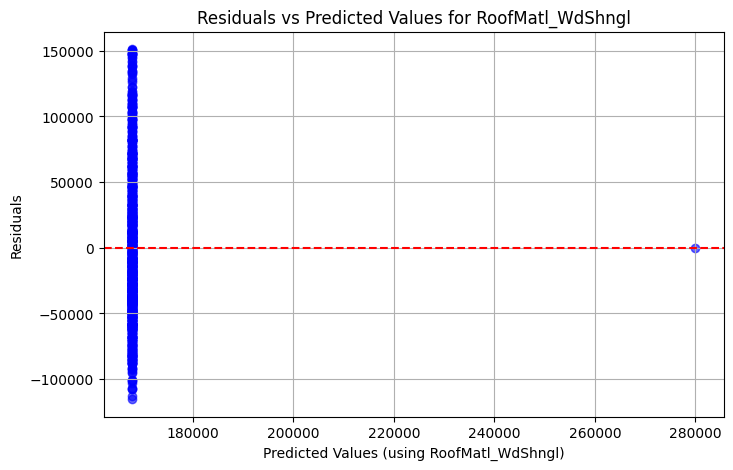

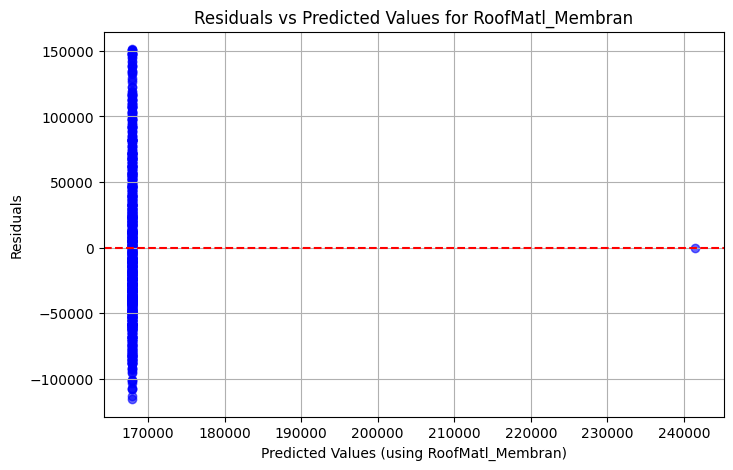

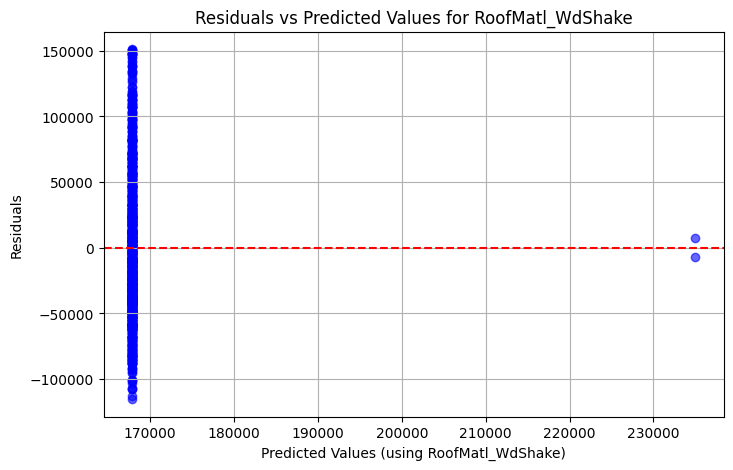

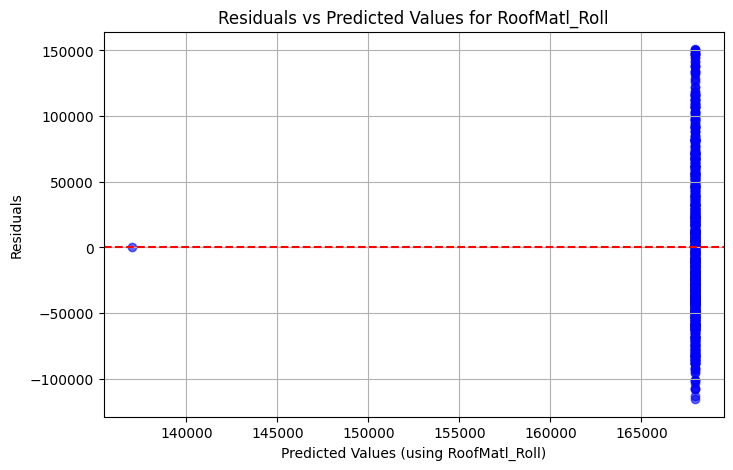

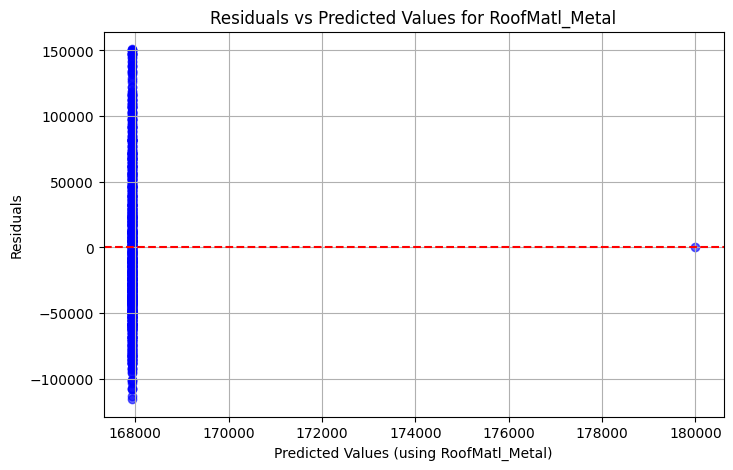

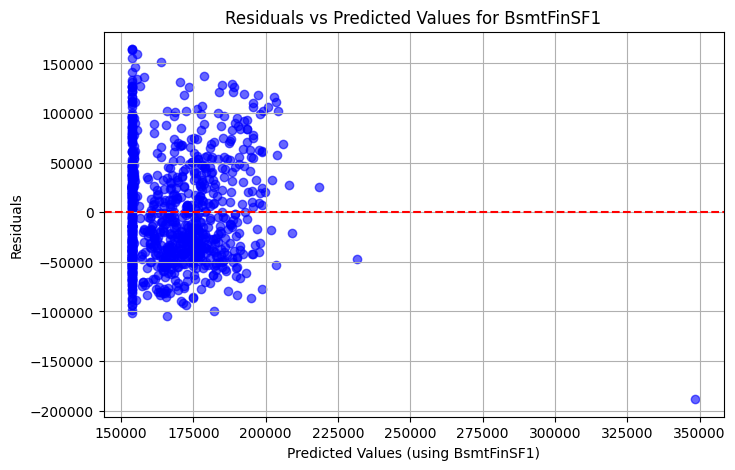

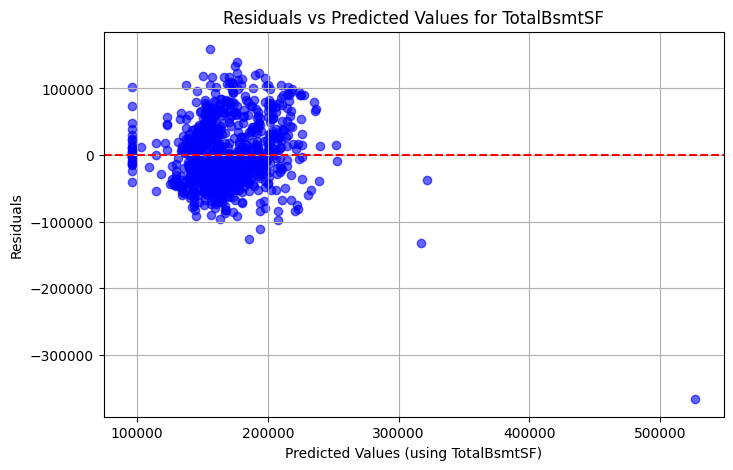

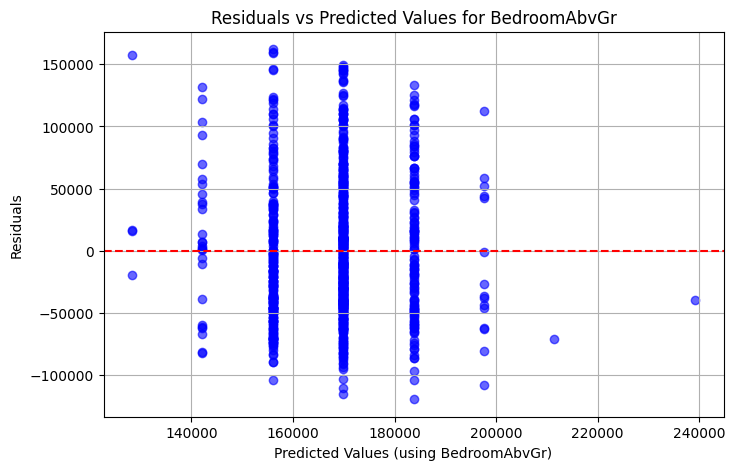

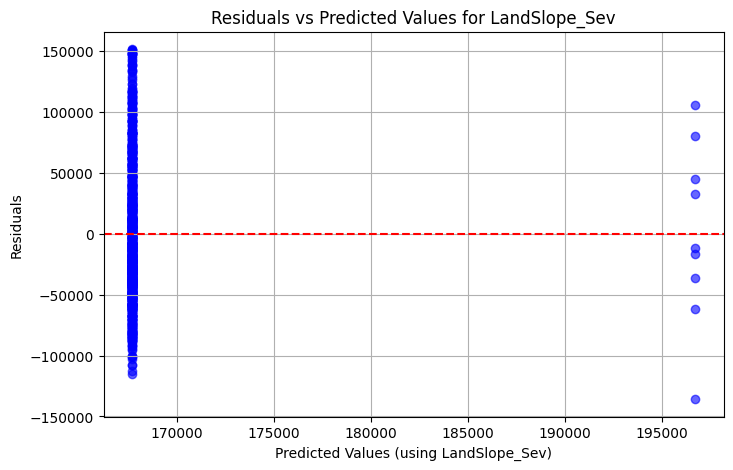

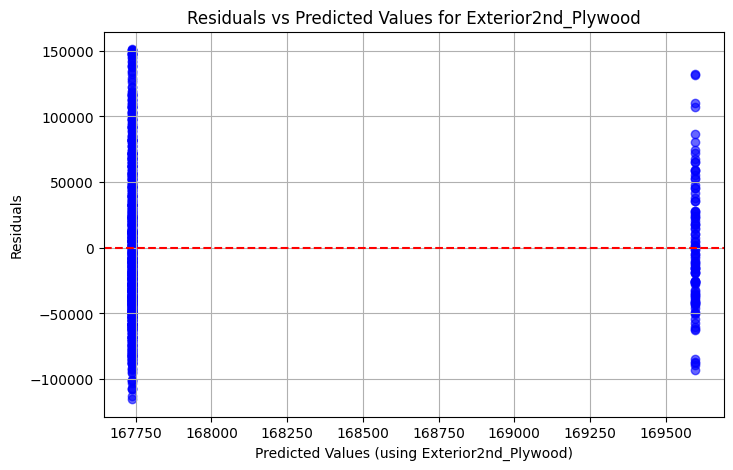

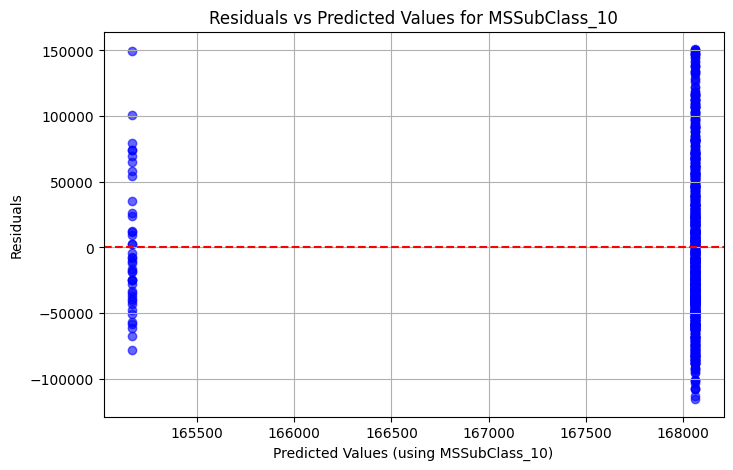

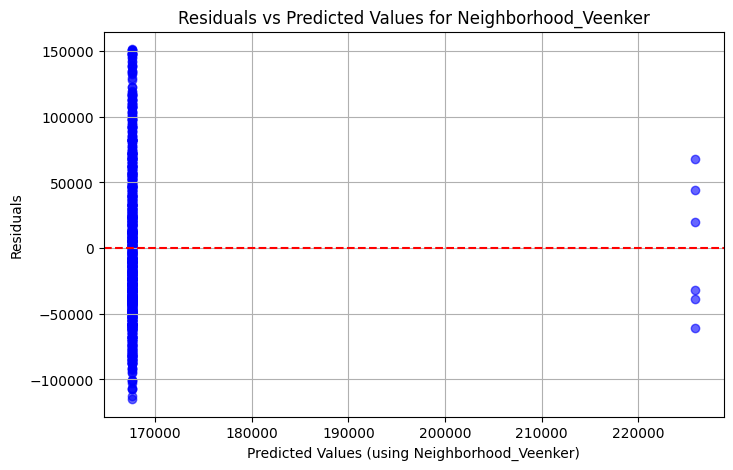

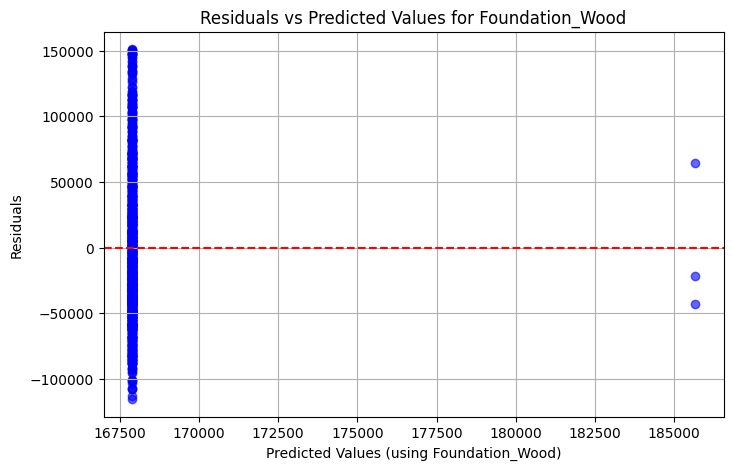

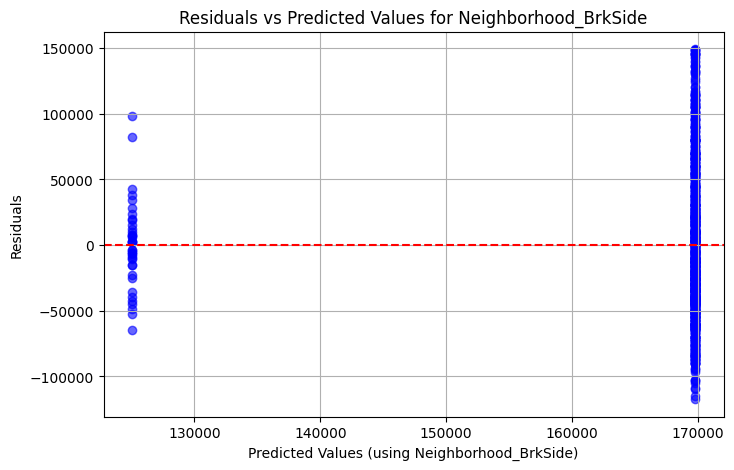

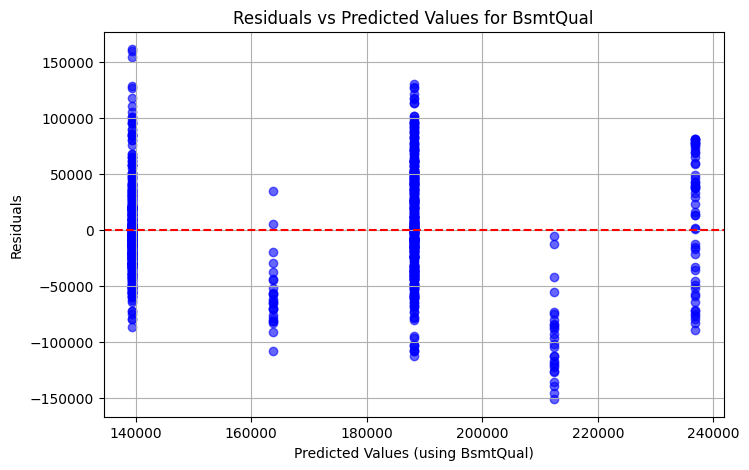

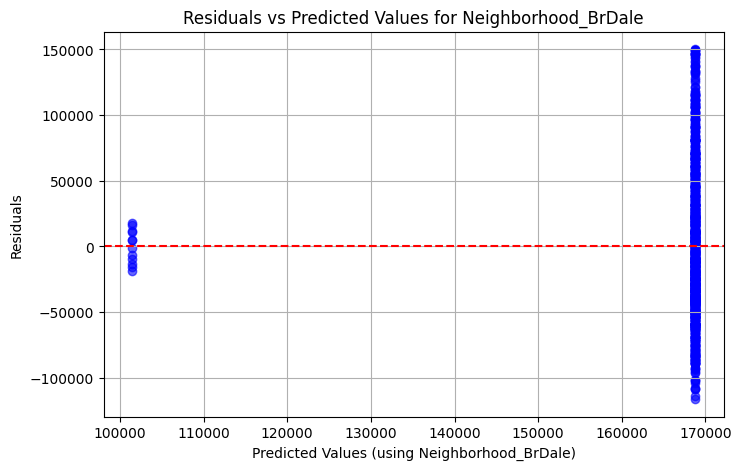

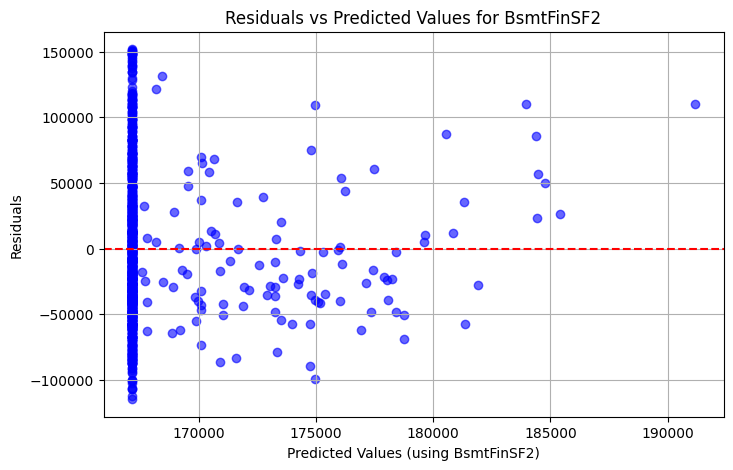

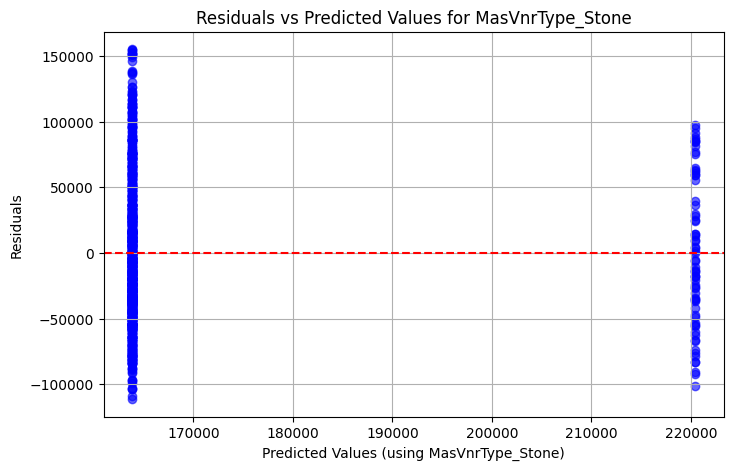

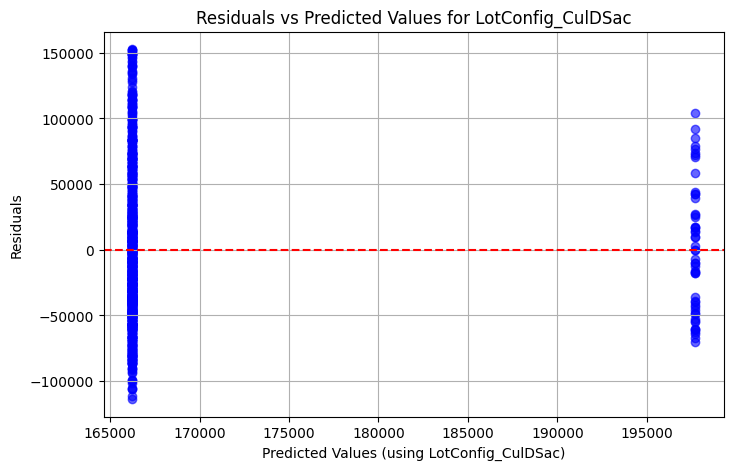

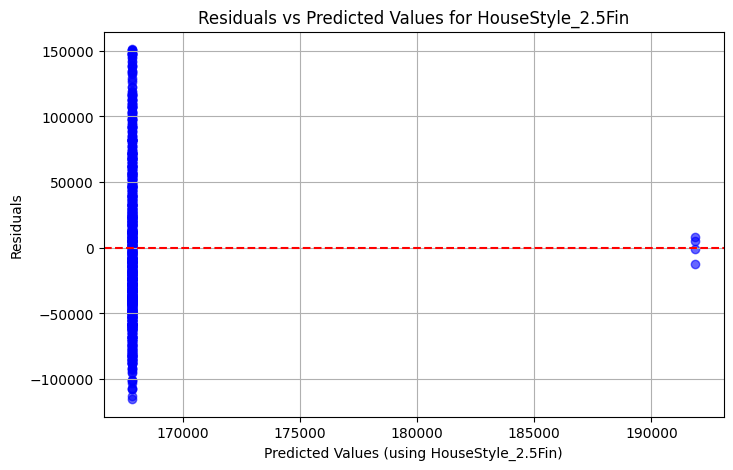

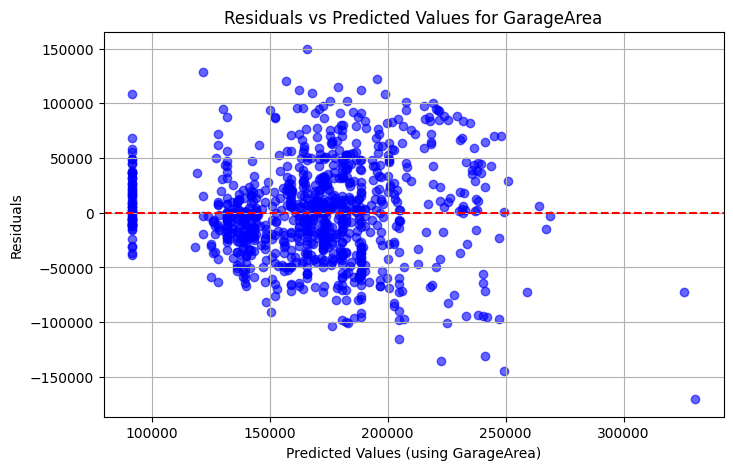

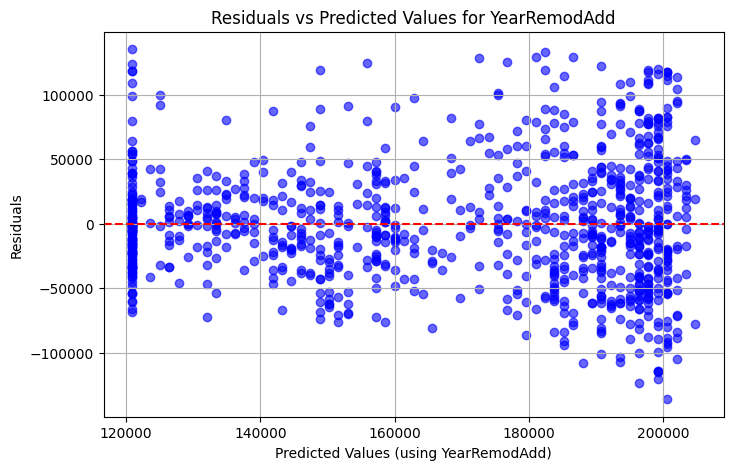

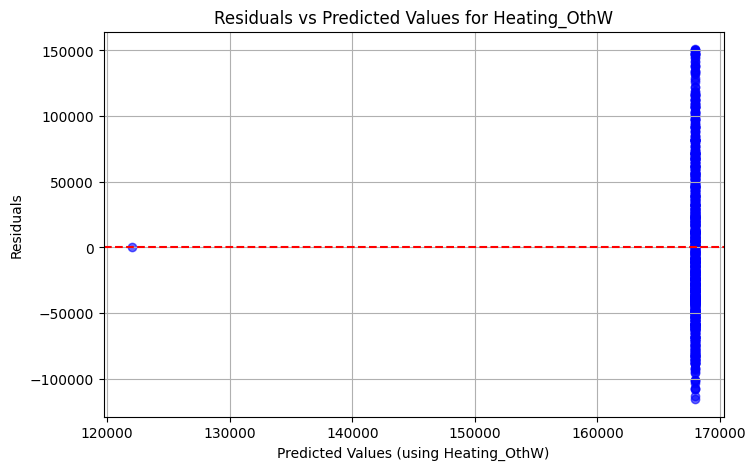

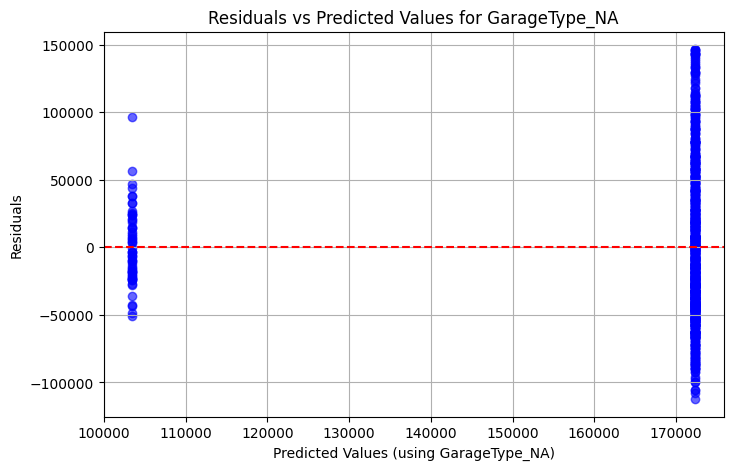

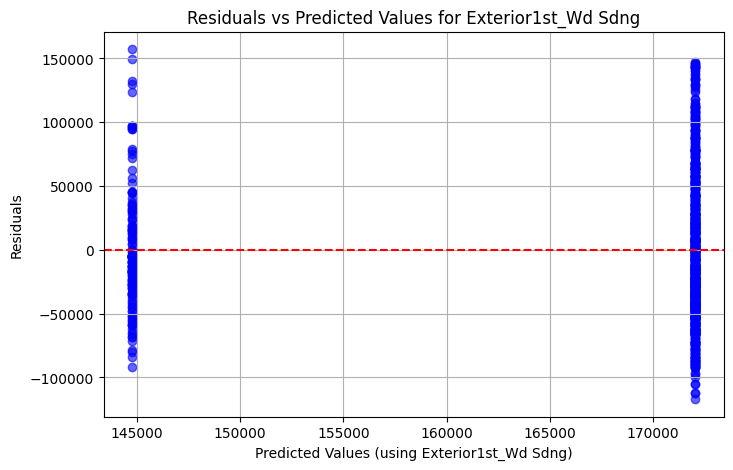

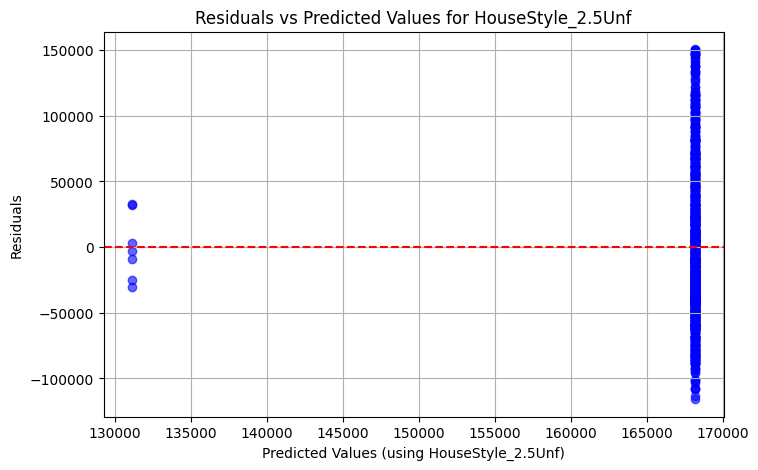

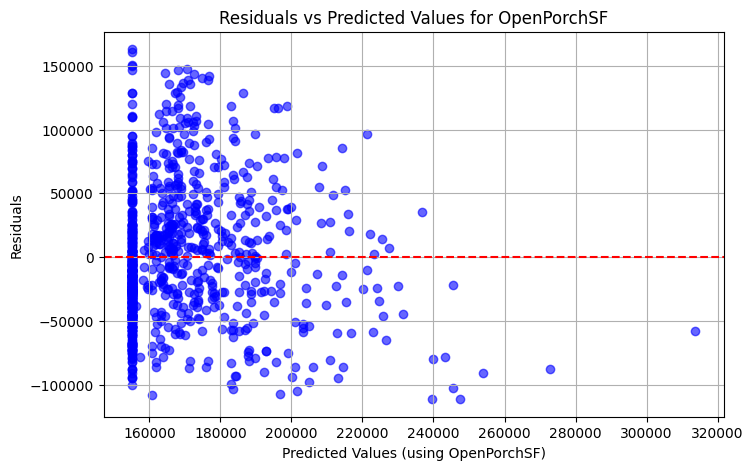

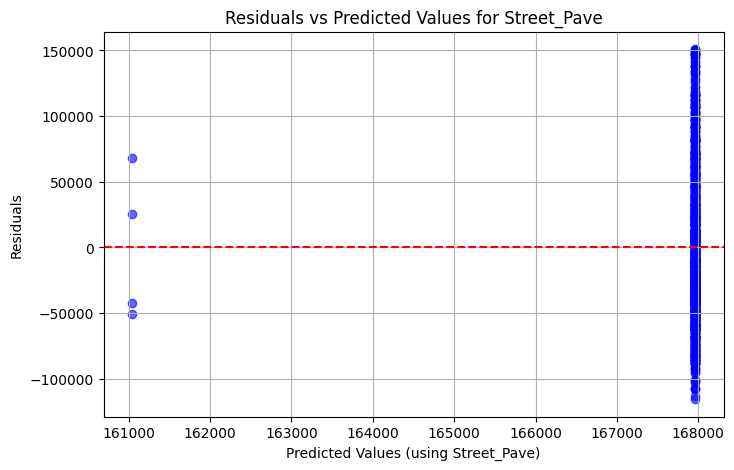

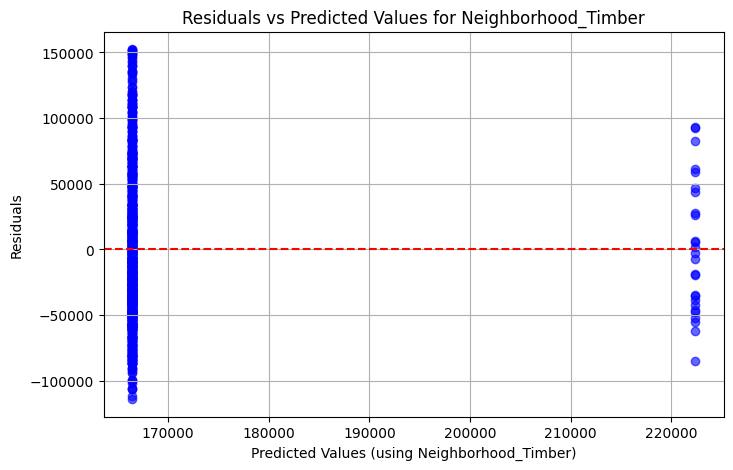

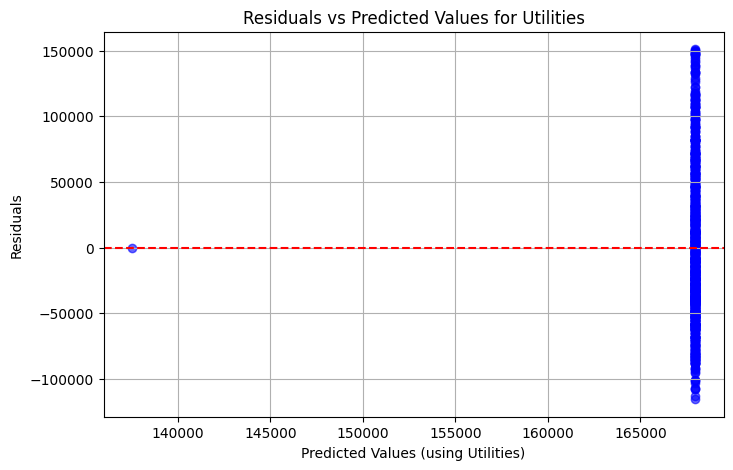

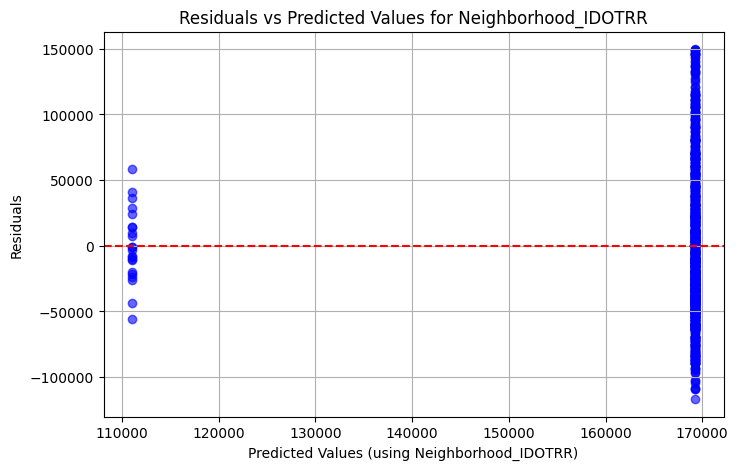

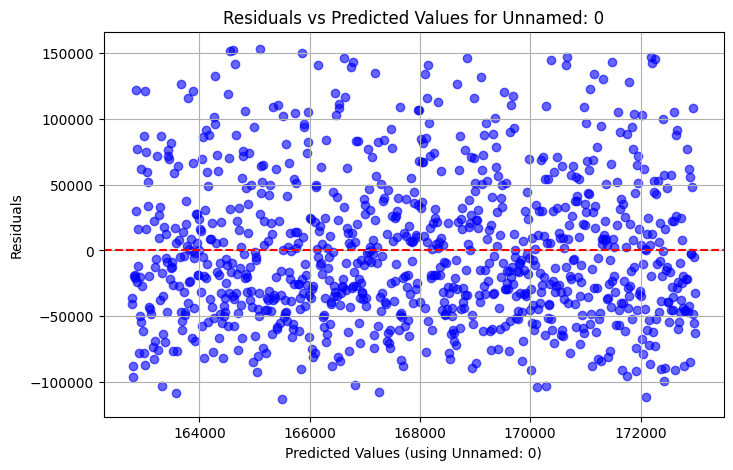

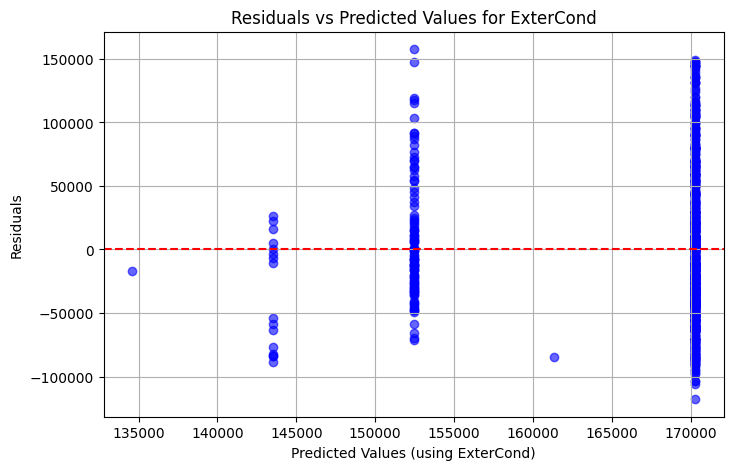

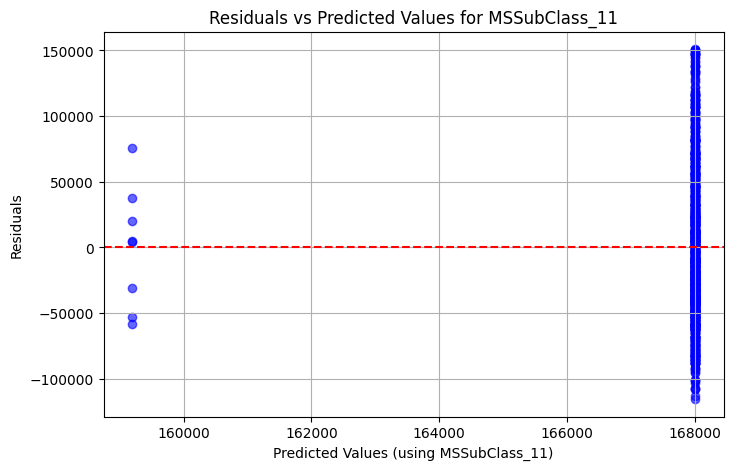

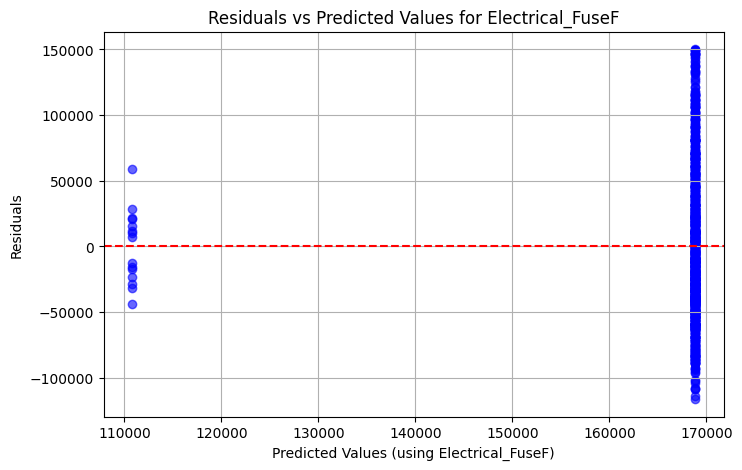

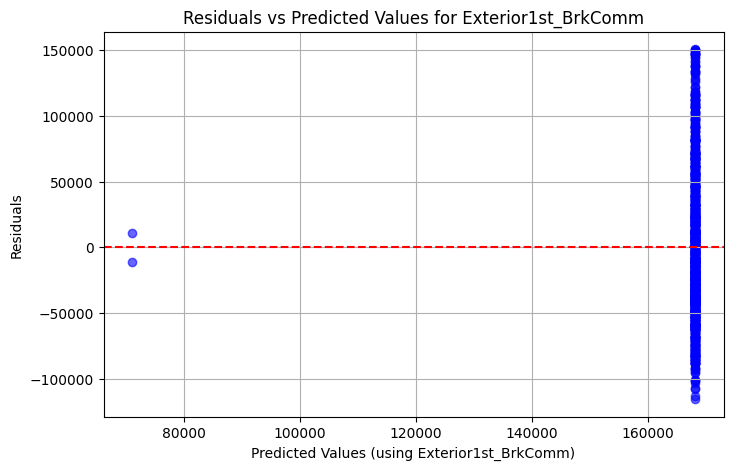

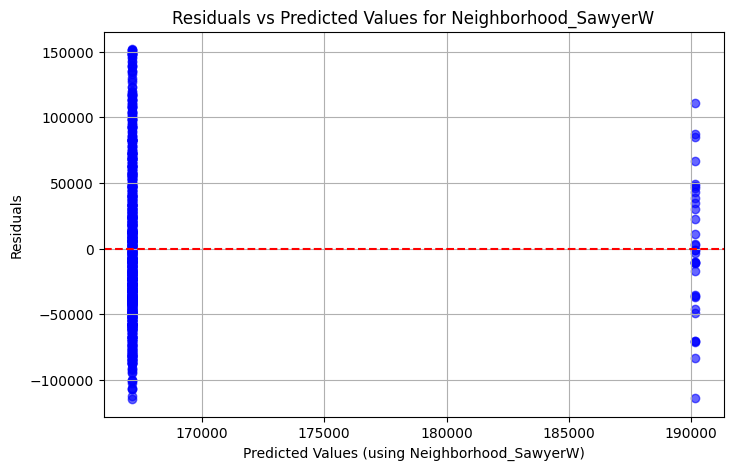

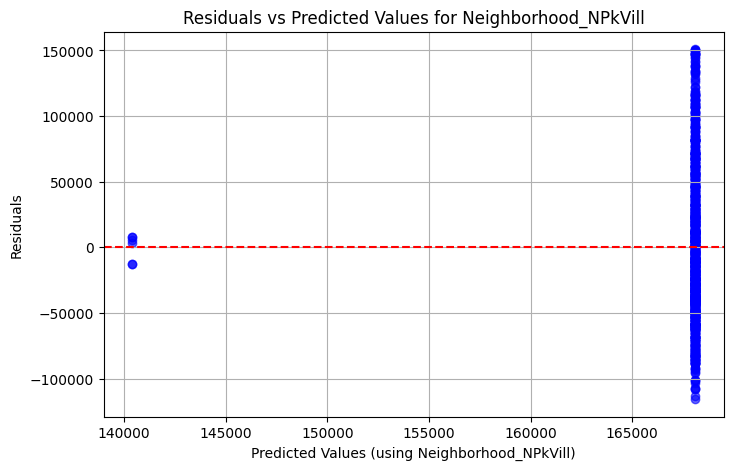

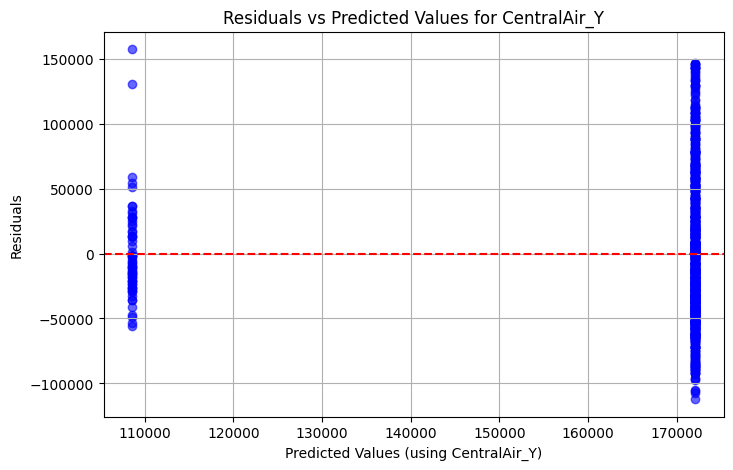

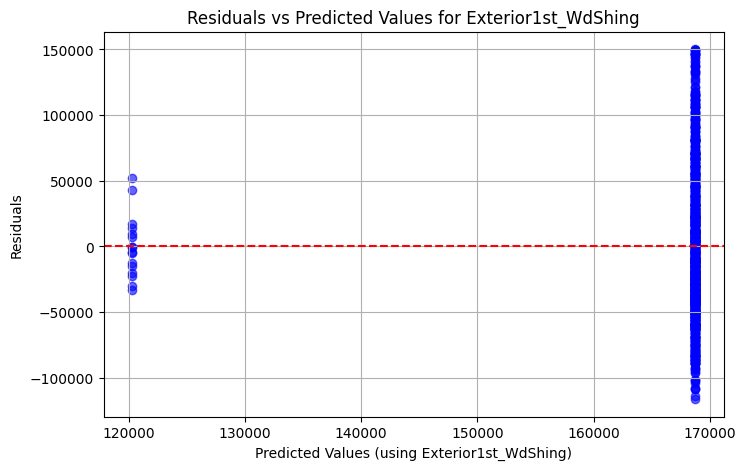

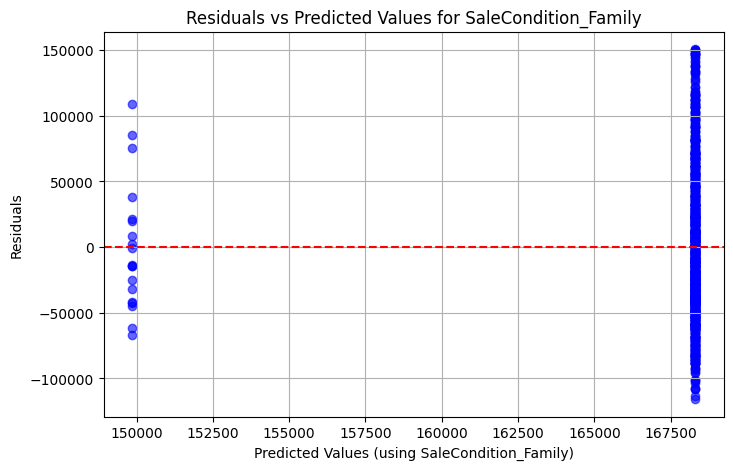

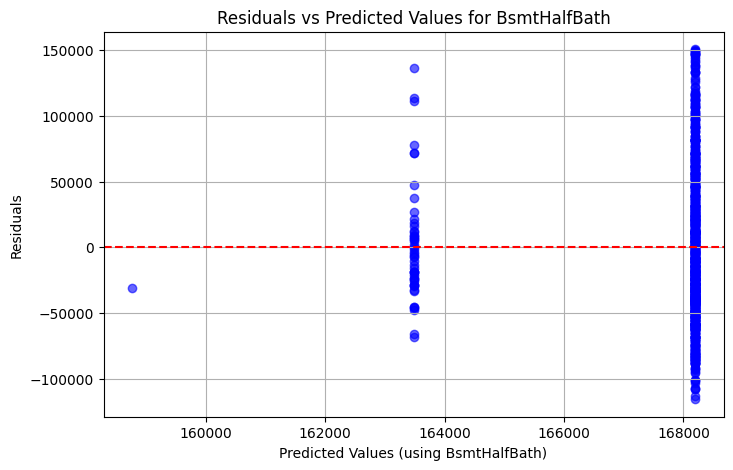

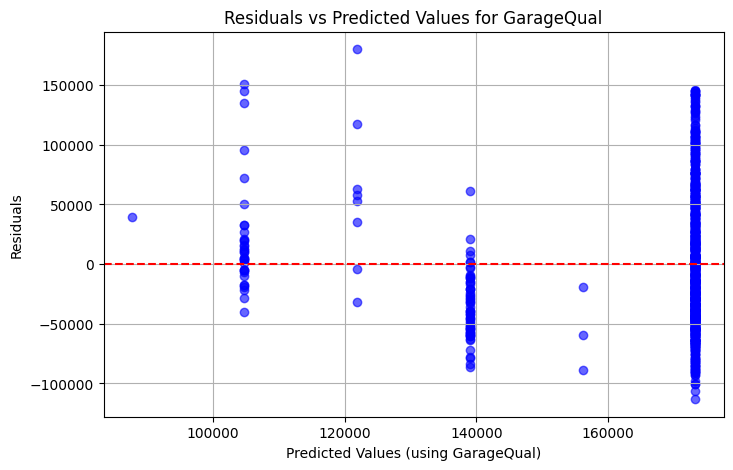

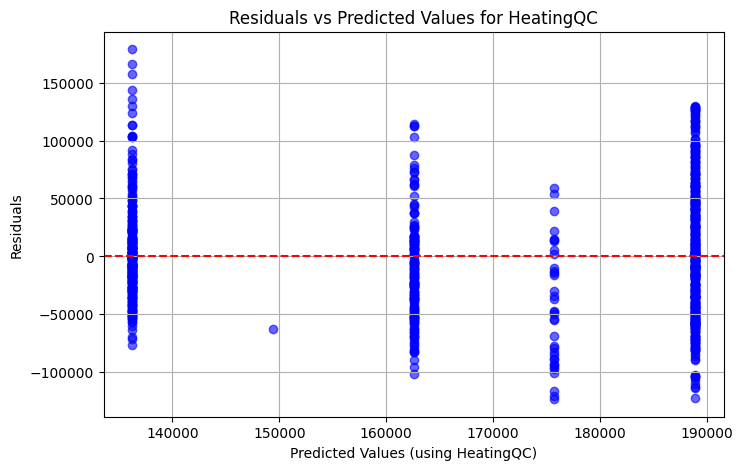

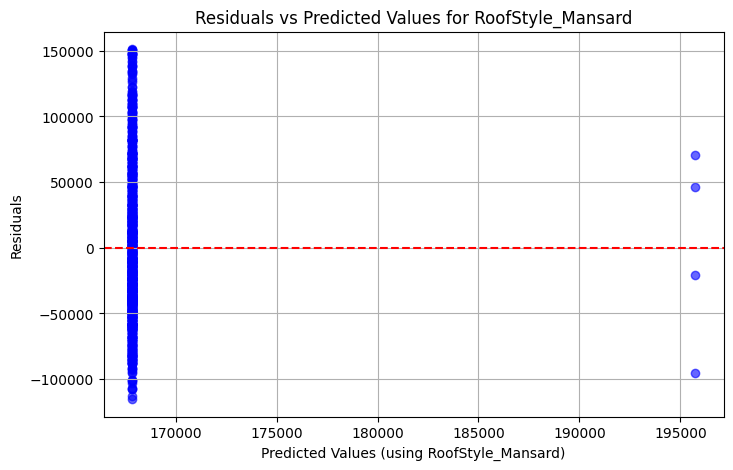

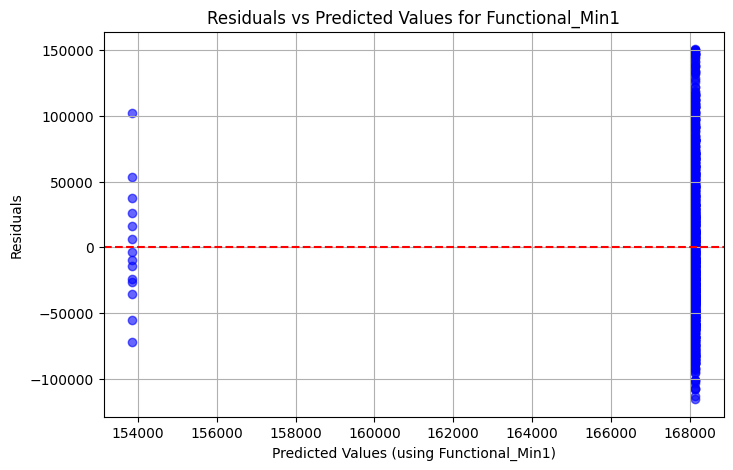

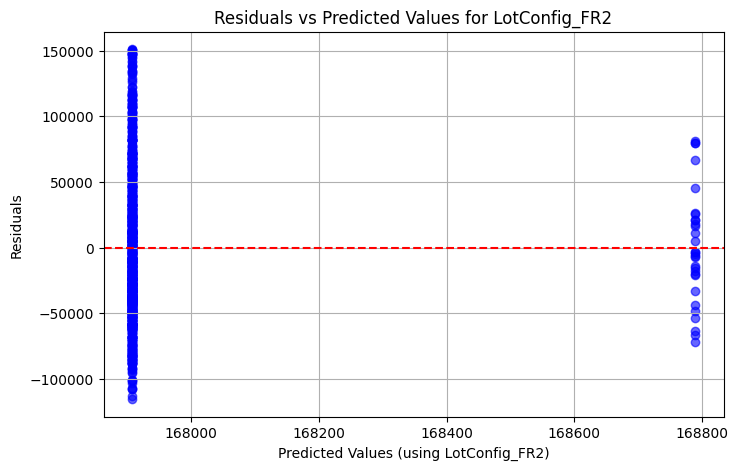

In [44]:
Y = train_data_filtered['SalePrice']

for predictor in best_predictors:
    X_single = train_data_filtered[[predictor]]

    model = LinearRegression()
    model.fit(X_single, Y)

    y_pred = model.predict(X_single)
    residuals = Y - y_pred

    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='blue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel(f'Predicted Values (using {predictor})')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted Values for {predictor}')
    plt.grid(True)
    plt.show()

Didn't see many variables that has a strong pattern here, which, theoretically, suggests that the data is linear. I tried to square the OverallCond column and didn't get a better result.

### Feature Engineering & Leaderboard Result 2

Root Train Mean Squared Error MSE: 14584.0249
Train R-squared                  : 0.9343
Root Test Mean Squared Error MSE : 15543.3038
Test R-squared                   : 0.9087


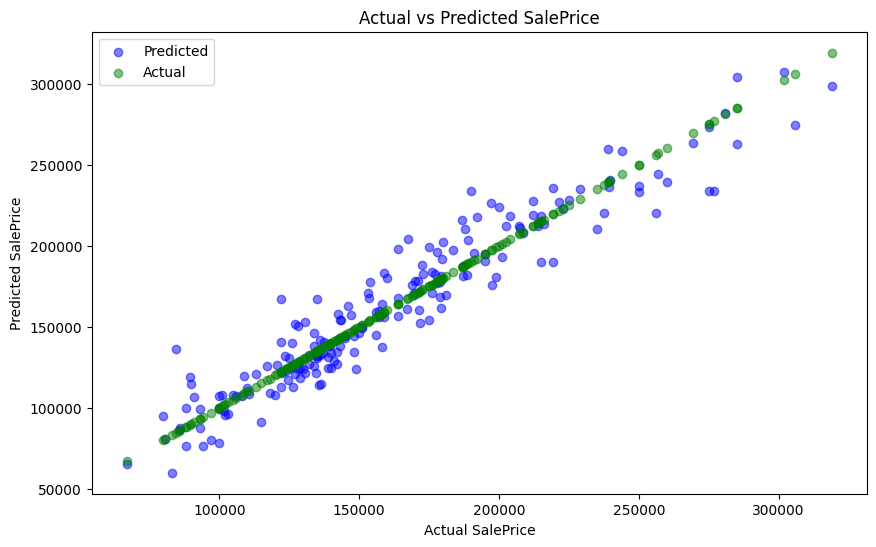

In [45]:
Attempt = train_data_filtered[best_predictors].copy()
Y = train_data_filtered['SalePrice']

Attempt['TotalPorchSF'] = train_data_filtered['OpenPorchSF'] + train_data_filtered['EnclosedPorch'] + train_data_filtered['3SsnPorch'] + train_data_filtered['ScreenPorch']
Attempt['TotalHouseSF'] = train_data_filtered['1stFlrSF'] + train_data_filtered['2ndFlrSF'] + train_data_filtered['TotalBsmtSF']
Attempt['LotAreaPerRoom'] = train_data_filtered['LotArea'] / (train_data_filtered['TotRmsAbvGrd'] + 1)
Attempt['QualityLivingSF'] = train_data_filtered['OverallQual'] * train_data_filtered['GrLivArea']
Attempt['HouseQualityIndex'] = train_data_filtered['OverallQual'] * train_data_filtered['OverallCond']
Attempt['GarageAge'] = train_data_filtered['YrSold'] - train_data_filtered['GarageYrBlt']

predict(Attempt, Y)

In [50]:
# Test the model on the whole data set.
X = Attempt
Y = train_data_filtered['SalePrice']
model = LinearRegression()
model.fit(X, Y)
predictions = model.predict(Attempt)
mse = mean_squared_error(train_data_filtered['SalePrice'], predictions)
print(f"RMSE: {sqrt(mse)}")

RMSE: 14493.687025487443


In [51]:
test_data_attempt = test_data[best_predictors].copy()

test_data_attempt['TotalPorchSF'] = test_data['OpenPorchSF'] + test_data['EnclosedPorch'] + test_data['3SsnPorch'] + test_data['ScreenPorch']
test_data_attempt['TotalHouseSF'] = test_data['1stFlrSF'] + test_data['2ndFlrSF'] + test_data['TotalBsmtSF']
test_data_attempt['LotAreaPerRoom'] = test_data['LotArea'] / (test_data['TotRmsAbvGrd'] + 1)
test_data_attempt['QualityLivingSF'] = test_data['OverallQual'] * test_data['GrLivArea']
test_data_attempt['HouseQualityIndex'] = test_data['OverallQual'] * test_data['OverallCond']
test_data_attempt['GarageAge'] = test_data['YrSold'] - test_data['GarageYrBlt']


X = Attempt
Y = train_data_filtered['SalePrice']
model = LinearRegression()
model.fit(X, Y)
predictions = model.predict(test_data_attempt)

#convert the predictions to a LIST of POSITIVE INTEGERS (do not submit decimals!)
list_predictions = predictions.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[198797, 137820, 118932, 140020, 125079, 242158, 74194, 181336, 154771, 170907, 148296, 269338, 275028, 174501, 150460, 389567, 132516, 158619, 214341, 73621, 122935, 201191, 163438, 188341, 120230, 117436, 196742, 194017, 178379, 112664, 131795, 153982, 315597, 241909, 159380, 175390, 101664, 140582, 220686, 215870, 152206, 169468, 207064, 110809, 135073, 101542, 124119, 235073, 268791, 184149, 247662, 174235, 123927, 209232, 169075, 177524, 114030, 198941, 146301, 127424, 120575, 98311, 149435, 131848, 210058, 242849, 185894, 217860, 264540, 98552, 218743, 249590, 78774, 236683, 158842, 212417, 110659, 183084, 114166, 166636, 129189, 181186, 227500, 235026, 130205, 241115, 274564, 138496, 282495, 180844, 170979, 189391, 315511, 144019, 145927, 83002, 134881, 210929, 154209, 95662, 203471, 137694, 288099, 171942, 124675, 124155, 205697, 155055, 284013, 296643, 217467, 210698, 57229, 139658, 107994, 141871, 147452, 221763, 248675, 288365, 245831, 209334, 306138, 144322, 110031, 196037,

This gives me a better result, on the leaderboard, it's 22358

### Interaction Terms

Loop through variables to form interaction terms, add one into the model at a time, to see if we can further improve the model results.

Streaming output truncated to the last 5000 lines.
No improvement with RoofMatl_WdShngl_LotAreaPerRoom, skipping.
No improvement with RoofMatl_WdShngl_QualityLivingSF, skipping.
No improvement with RoofMatl_WdShngl_HouseQualityIndex, skipping.
No improvement with RoofMatl_WdShngl_GarageAge, skipping.
No improvement with RoofMatl_Membran_OverallQual, skipping.
No improvement with RoofMatl_Membran_GrLivArea, skipping.
No improvement with RoofMatl_Membran_YearBuilt, skipping.
No improvement with RoofMatl_Membran_MSSubClass_1, skipping.
No improvement with RoofMatl_Membran_GarageCars, skipping.
No improvement with RoofMatl_Membran_Condition2_PosN, skipping.
No improvement with RoofMatl_Membran_OverallCond, skipping.
No improvement with RoofMatl_Membran_BsmtFullBath, skipping.
No improvement with RoofMatl_Membran_KitchenQual, skipping.
No improvement with RoofMatl_Membran_Neighborhood_ClearCr, skipping.
No improvement with RoofMatl_Membran_MSZoning_RM, skipping.
No improvement with RoofMatl

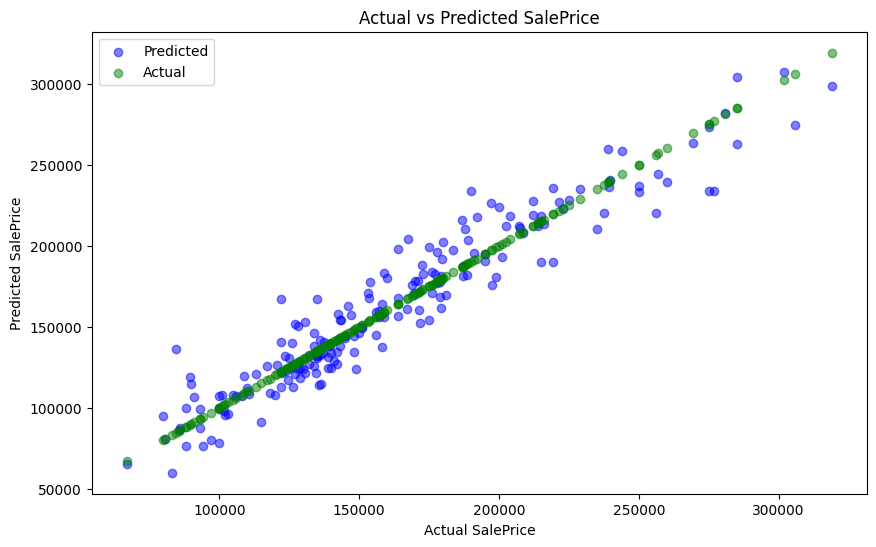

In [ ]:
X = Attempt
Y = train_data_filtered["SalePrice"]
lowest_test_mse = 15543.3038

X_best = X.copy()  # Keep a copy of X that contains the best set of features

def test_joint(X, Y):
    X_train, X_test, Y_train, Y_test = split_data(X, Y)
    model = sm.OLS(Y_train, sm.add_constant(X_train))
    model = model.fit()
    Y_test_pred = model.predict(sm.add_constant(X_test))
    test_mse = mean_squared_error(Y_test, Y_test_pred)
    train_mse = mean_squared_error(Y_train, model.predict(sm.add_constant(X_train)))
    return train_mse, test_mse

for i in X.columns:
    for j in X.columns:
        joint_feature_name = f'{i}_{j}'
        X_temp = X_best.copy()  # Work on a copy of the best feature set
        X_temp[joint_feature_name] = X[i] * X[j]  # Create the joint feature
        X_temp.drop(columns=[i, j], inplace=True)  # Remove the original features
        train_mse, test_mse = test_joint(X_temp, Y)

        # If the test MSE improves, keep the joint feature
        if test_mse < lowest_test_mse:
            X_best[joint_feature_name] = X[i] * X[j]  # Add the joint feature to the best set
            lowest_test_mse = test_mse  # Update the lowest test MSE
            print(f"New lowest test MSE with {joint_feature_name}: {sqrt(lowest_test_mse)}")
        else:
            print(f"No improvement with {joint_feature_name}, skipping.")
            X_temp.drop(columns=[joint_feature_name], inplace=True)  # Remove the joint feature

# Final model evaluation with the best set of joint features

predict(X_best, Y)

This suggests that we skipped every interaction term, none of them can make the test mse lower @Possibel_improvements

# Demonstration of Overfitting vs Underfitting

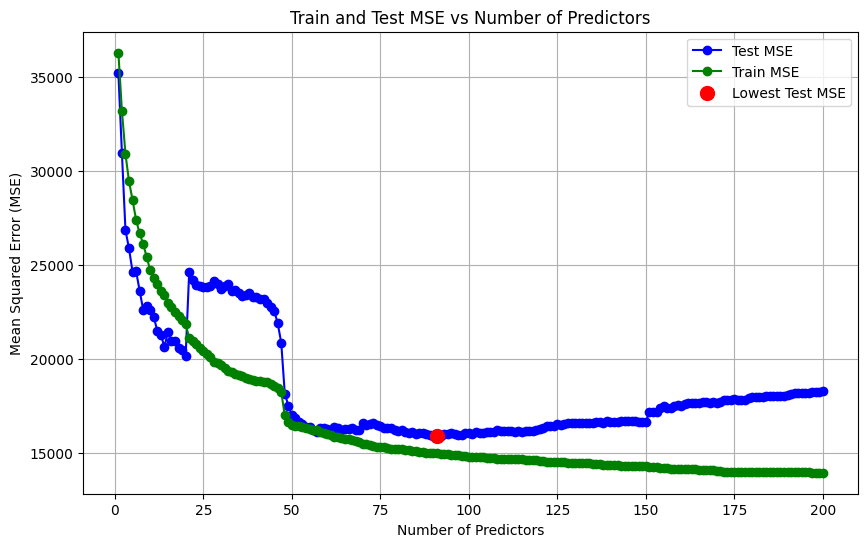

Best predictors: ['OverallQual', 'GrLivArea', 'YearBuilt', 'MSSubClass_1', 'GarageCars', 'Condition2_PosN', 'OverallCond', 'BsmtFullBath', 'KitchenQual', 'Neighborhood_ClearCr', 'MSZoning_RM', 'Condition1_Norm', 'Neighborhood_NridgHt', 'Fireplaces', 'PoolArea', 'MSSubClass_4', 'Neighborhood_NoRidge', 'ScreenPorch', 'Neighborhood_Somerst', 'Neighborhood_Crawfor', 'PoolQC', 'GarageFinish', 'Neighborhood_Edwards', 'BsmtExposure', 'KitchenAbvGr', 'Functional_Typ', 'SaleCondition_Normal', 'SaleCondition_Partial', 'Neighborhood_StoneBr', 'BldgType', 'Exterior1st_BrkFace', 'LotArea', 'LotFrontage', 'Neighborhood_NAmes', 'Condition1_RRAe', 'RoofMatl_Tar&Grv', 'Exterior2nd_Wd Shng', 'WoodDeckSF', 'Exterior1st_HdBoard', 'MasVnrType_None', 'ExterQual', 'YrSold', 'RoofMatl_CompShg', 'RoofMatl_WdShngl', 'RoofMatl_Membran', 'RoofMatl_WdShake', 'RoofMatl_Roll', 'RoofMatl_Metal', 'BsmtFinSF1', 'TotalBsmtSF', 'BedroomAbvGr', 'LandSlope_Sev', 'Exterior2nd_Plywood', 'MSSubClass_10', 'Neighborhood_Veenker

In [52]:
best_predictors, best_test_mse = plot_u_shape(selected_predictors[:200], train_data_filtered.drop(columns = ['SalePrice']), train_data_filtered['SalePrice'])

print(f"Best predictors: {best_predictors}")

**Overfitting vs Underfitting**  

<u>*Overfitting*</u> means the model trys to chase some of the data points too hard that it **ignored the general pattern** of the whole data set. It often occures when the model is too complex, for example, when the model has too many features or high-degree polynomial features. This will cause the model to behave well on the training data set, while **behaving poor on the test data set**, becasue it fit into too much noise of the data.

<u>*Underfitting*</u> means the model is too simple to find the general pattern and structure of data set. This may be caused by not enough features, and maybe the choice of wrong model/regression method to fit the data. An underfitting modle **behaves poor on both** train data set and test data set.

**U-Shaped Curve**

For the U-shaped graph generated by forward selection above,
- in the beginning state, when there are very few features in the model, the training mse and test mse are both high, and they are dropping when I add more features to the model. This is the underfitting stage.
- At some point (here it is when there are 90 features in the model) the test mse gets to the lowest point, it will not decrease any more even if more feature are added to the model. This is when we extract the group of 90 predictors that gives lowest test mse.
- However, when more feature is added, the test mse will increase while train mse continues to decrease, this is the stage of overfitting. The model is fitting the noise in the data rather than general patterns.
- As the model went from having less features to having more features, the generalization gap first became lower until it reached lowest, then it became higher and higher.

# Final Model

In [55]:
# Test the model on the whole data set.
X = Attempt
Y = train_data_filtered['SalePrice']
model = LinearRegression()
model.fit(X, Y)
predictions = model.predict(Attempt)
mse = mean_squared_error(train_data_filtered['SalePrice'], predictions)
print(f"RMSE: {sqrt(mse)}")

RMSE: 14493.687025487443


In [56]:
test_data_attempt = test_data[best_predictors].copy()

test_data_attempt['TotalPorchSF'] = test_data['OpenPorchSF'] + test_data['EnclosedPorch'] + test_data['3SsnPorch'] + test_data['ScreenPorch']
test_data_attempt['TotalHouseSF'] = test_data['1stFlrSF'] + test_data['2ndFlrSF'] + test_data['TotalBsmtSF']
test_data_attempt['LotAreaPerRoom'] = test_data['LotArea'] / (test_data['TotRmsAbvGrd'] + 1)
test_data_attempt['QualityLivingSF'] = test_data['OverallQual'] * test_data['GrLivArea']
test_data_attempt['HouseQualityIndex'] = test_data['OverallQual'] * test_data['OverallCond']
test_data_attempt['GarageAge'] = test_data['YrSold'] - test_data['GarageYrBlt']


X = Attempt
Y = train_data_filtered['SalePrice']
model = LinearRegression()
model.fit(X, Y)
predictions = model.predict(test_data_attempt)

#convert the predictions to a LIST of POSITIVE INTEGERS (do not submit decimals!)
list_predictions = predictions.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[198797, 137820, 118932, 140020, 125079, 242158, 74194, 181336, 154771, 170907, 148296, 269338, 275028, 174501, 150460, 389567, 132516, 158619, 214341, 73621, 122935, 201191, 163438, 188341, 120230, 117436, 196742, 194017, 178379, 112664, 131795, 153982, 315597, 241909, 159380, 175390, 101664, 140582, 220686, 215870, 152206, 169468, 207064, 110809, 135073, 101542, 124119, 235073, 268791, 184149, 247662, 174235, 123927, 209232, 169075, 177524, 114030, 198941, 146301, 127424, 120575, 98311, 149435, 131848, 210058, 242849, 185894, 217860, 264540, 98552, 218743, 249590, 78774, 236683, 158842, 212417, 110659, 183084, 114166, 166636, 129189, 181186, 227500, 235026, 130205, 241115, 274564, 138496, 282495, 180844, 170979, 189391, 315511, 144019, 145927, 83002, 134881, 210929, 154209, 95662, 203471, 137694, 288099, 171942, 124675, 124155, 205697, 155055, 284013, 296643, 217467, 210698, 57229, 139658, 107994, 141871, 147452, 221763, 248675, 288365, 245831, 209334, 306138, 144322, 110031, 196037,

Final Result: 22358

# Possible Improvements

1. When dealing with `NA` values, there was a column called "Electrical", it's value is like this,
       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	  Mixed
it should not be just replaced by the most frequent value. Another way to do this is using machine learning to predict this missing value, which will add more intepretability to the data set and final results.

2. For the U-shaped Curve, I feel like something weird was going on with the model when there were 20 - 50 varibales. I have a feeling that if I figure it out, it's going to give something that can even lower the final test mse.

3. When adding interaction terms, the model didn't improve, which I think is not supposed to be like this. Because on my old submission of the project, interaction terms improved the model performance at the sacrifice of multicollinearity which is the stability of the model.